# Rolling Regression Analysis with Fama-French Factors and Industry Portfolios 

**Note**: This is an educational/research tool. Not financial advice. Always conduct your own due diligence before making investment decisions.

## 1. Introduction

Rolling regression is a powerful time series technique used to model relationships between variables that may change over time. Unlike standard linear regression, which assumes constant parameters, rolling regression estimates model parameters using a fixed window of data that moves through the time series. This approach is particularly valuable in financial econometrics where relationships between assets, risk factors, and market conditions evolve dynamically.

### Key Concepts:
- **Time-varying parameters**: Rolling regression captures how regression coefficients change over different time periods
- **Window size**: The number of observations used in each regression estimation
- **Parameter trajectories**: Enables visualization of how coefficients evolve over time
- **Structural break detection**: Helps identify periods where relationships fundamentally change

### Applications in Finance:
- Asset pricing model validation
- Risk management and beta estimation
- Portfolio performance analysis
- Market regime detection
- Factor timing strategies

## 2. Import Required Libraries

Library Documentation:

pandas: Data manipulation and analysis

pandas-datareader: Financial data acquisition

statsmodels: Statistical modeling including RollingOLS

matplotlib/seaborn: Data visualization

numpy: Numerical computations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Set visualization style
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

# 3. Data Acquisition and Exploration
## 3.1 Loading Fama-French Three-Factor Data

In [2]:
# Download Fama-French 3 factors (Market, Size, Value)
factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]
print("Fama-French Three Factors Dataset:")
print(f"Shape: {factors.shape}")
print(f"Date Range: {factors.index.min()} to {factors.index.max()}")
print("\nFirst 10 observations:")
print(factors.head(10))

Fama-French Three Factors Dataset:
Shape: (1192, 4)
Date Range: 1926-07 to 2025-10

First 10 observations:
         Mkt-RF   SMB   HML    RF
Date                             
1926-07    2.89 -2.55 -2.39  0.22
1926-08    2.64 -1.14  3.81  0.25
1926-09    0.38 -1.36  0.05  0.23
1926-10   -3.27 -0.14  0.82  0.32
1926-11    2.54 -0.11 -0.61  0.31
1926-12    2.62 -0.07  0.06  0.28
1927-01   -0.05 -0.32  4.58  0.25
1927-02    4.17  0.07  2.72  0.26
1927-03    0.14 -1.77 -2.38  0.30
1927-04    0.47  0.39  0.65  0.25


/tmp/ipykernel_95395/1458912113.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]
/tmp/ipykernel_95395/1458912113.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1-1-1926")[0]


Dataset Description:

Mkt-RF: Market excess return (Market return minus Risk-free rate)

SMB: Small Minus Big (size factor)

HML: High Minus Low (value factor)

RF: Risk-free rate (one-month Treasury bill rate)

Frequency: Monthly returns from July 1926

Source: Kenneth French's Data Library

## 3.2 Factor Correlation Analysis

Correlation Matrix of Fama-French Factors:
          Mkt-RF       SMB       HML        RF
Mkt-RF  1.000000  0.320020  0.227334 -0.063921
SMB     0.320020  1.000000  0.126143 -0.053245
HML     0.227334  0.126143  1.000000  0.017218
RF     -0.063921 -0.053245  0.017218  1.000000

Correlation Statistics:
Mean absolute correlation: 0.3510
Maximum correlation: 1.0000
Minimum correlation: 0.0172


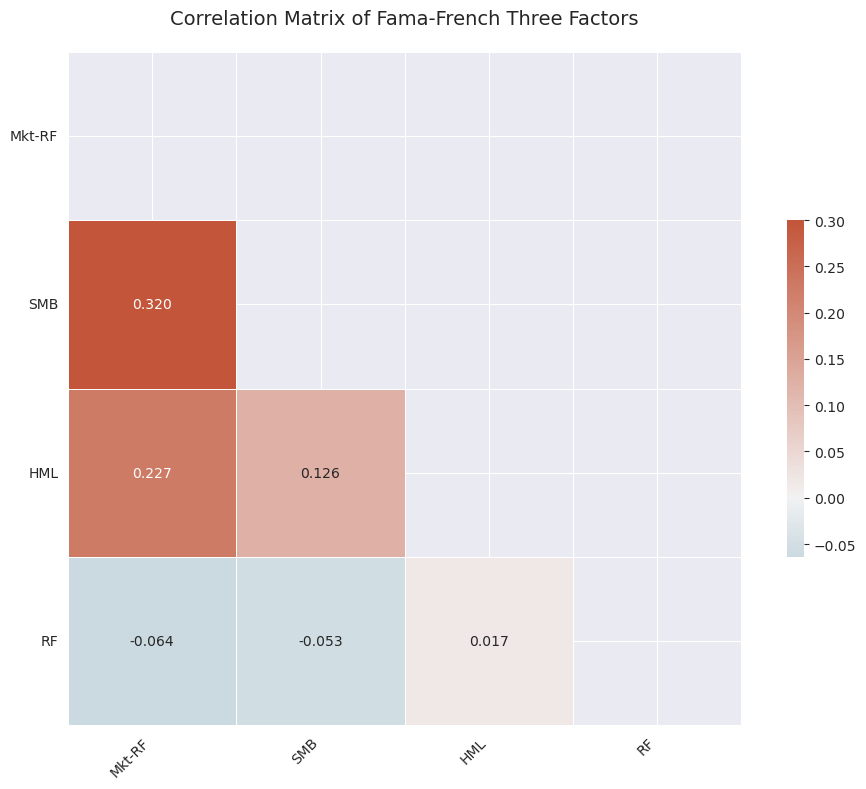

In [3]:
# Calculate correlation matrix
factors_corr = factors.corr()
print("Correlation Matrix of Fama-French Factors:")
print(factors_corr)
print(f"\nCorrelation Statistics:")
print(f"Mean absolute correlation: {factors_corr.abs().mean().mean():.4f}")
print(f"Maximum correlation: {factors_corr.abs().max().max():.4f}")
print(f"Minimum correlation: {factors_corr.abs().min().min():.4f}")

# Create enhanced correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(factors_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(factors_corr, 
            mask=mask,
            cmap=cmap,
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True,
            fmt='.3f',
            annot_kws={'size': 10})

plt.title('Correlation Matrix of Fama-French Three Factors', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Analysis of Fama-French Factor Correlations:

Market Factor Dominance: The market factor (Mkt-RF) shows moderate positive correlations with both size (SMB: 0.320) and value (HML: 0.227) factors, suggesting these factors often move in the same direction but are distinct enough to provide independent explanatory power.

Factor Independence: All correlations between risk factors are positive (0.126-0.320), indicating they generally capture complementary rather than opposing effects. However, the moderate correlation levels (average 0.351) confirm they represent distinct risk dimensions.

Risk-Free Rate Isolation: The risk-free rate (RF) shows minimal correlations with other factors (-0.064 to 0.017), confirming it operates as an independent component in the model, which is expected for a risk-free asset.

Lowest Relationship: The weakest relationship exists between the value factor (HML) and risk-free rate (0.017), suggesting value stocks' performance is virtually unrelated to interest rate movements in this dataset.

Diversification Potential: The modest inter-factor correlations (all below 0.35 excluding self-correlation) indicate good diversification potential when combining these factors in multi-factor models.

Key Implications for Portfolio Construction:

The factors provide relatively independent sources of risk and return

Multi-factor strategies can benefit from diversification across these dimensions

The model structure with orthogonal factors is empirically supported

Value and size factors maintain sufficient independence from market movements to justify their inclusion in asset pricing models

Limitation: While correlations are moderate, they're not zero, suggesting some overlap in the economic risks captured by different factors.

## 3.3 Loading Industry Portfolio Returns

In [4]:
# Download 10 Industry Portfolios
industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
print("Industry Portfolios Dataset:")
print(f"Shape: {industries.shape}")
print(f"Date Range: {industries.index.min()} to {industries.index.max()}")
print("\nAvailable Industries:")
for i, col in enumerate(industries.columns, 1):
    print(f"{i:2d}. {col}")

print("\nFirst 5 observations:")
print(industries.head())

Industry Portfolios Dataset:
Shape: (1192, 10)
Date Range: 1926-07 to 2025-10

Available Industries:
 1. NoDur
 2. Durbl
 3. Manuf
 4. Enrgy
 5. HiTec
 6. Telcm
 7. Shops
 8. Hlth
 9. Utils
10. Other

First 5 observations:
         NoDur  Durbl  Manuf  Enrgy  HiTec  Telcm  Shops  Hlth  Utils  Other
Date                                                                        
1926-07   1.44  13.90   4.70  -1.14   2.90   0.83   0.12  1.85   7.04   2.14
1926-08   3.99   3.70   2.80   3.43   2.66   2.17  -0.72  4.17  -1.70   4.35
1926-09   1.15   4.98   1.17  -3.30  -0.39   2.42   0.21  0.69   2.05   0.31
1926-10  -1.24  -8.39  -3.65  -0.78  -4.58  -0.11  -2.29 -0.57  -3.27  -2.85
1926-11   5.21  -0.17   4.27   0.01   4.71   1.63   6.45  5.43   4.40   2.13


/tmp/ipykernel_95395/171802370.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
/tmp/ipykernel_95395/171802370.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
/tmp/ipykernel_95395/171802370.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industries = pdr.get_data_famafrench("10_Industry_Portfolios", start="1-1-1926")[0]
/tmp/ipykernel_95395/171802370.py:

Industry Portfolio Descriptions:

NoDur: Consumer Non-durables (Food, Tobacco, etc.)

Durbl: Consumer Durables (Cars, Appliances, etc.)

Manuf: Manufacturing (Machinery, Trucks, Planes, etc.)

Enrgy: Oil, Gas, and Coal Extraction and Products

HiTec: Business Equipment (Computers, Software, etc.)

Telcm: Telephone and Television Transmission

Shops: Wholesale, Retail, and Some Services

Hlth: Healthcare, Medical Equipment, and Drugs

Utils: Utilities

Other: Other sectors (Mines, Construction, etc.)

# 4. Rolling CAPM Estimation
## 4.1 Model Specification

We begin with a rolling Capital Asset Pricing Model (CAPM) that regresses the excess return of the Technology sector (HiTec) on the excess market return.

In [5]:
# Calculate excess returns
tech_excess = industries['HiTec'] - factors['RF'].values
market_excess = factors['Mkt-RF']

# Prepare design matrix (add constant for intercept)
X = sm.add_constant(market_excess)
y = tech_excess

print("Dataset Information:")
print(f"Total observations: {len(y)}")
print(f"Sample period: {y.index[0]} to {y.index[-1]}")
print(f"\nTech sector excess return statistics:")
print(f"Mean: {y.mean():.4f}%")
print(f"Std Dev: {y.std():.4f}%")
print(f"Min: {y.min():.4f}%")
print(f"Max: {y.max():.4f}%")

Dataset Information:
Total observations: 1192
Sample period: 1926-07 to 2025-10

Tech sector excess return statistics:
Mean: 0.8984%
Std Dev: 7.1488%
Min: -33.9900%
Max: 51.7100%


The technology sector has delivered substantial excess returns, averaging nearly 0.9% monthly above the risk-free rate, highlighting its strong long-term performance premium. However, this outperformance comes with elevated volatility, as evidenced by the high standard deviation of 7.15%, indicating significant risk exposure. The extreme return range from -34% to +52% demonstrates the sector's cyclical nature and susceptibility to dramatic market movements. These characteristics suggest that while technology offers attractive return potential, it requires careful risk management and may benefit from dynamic beta hedging strategies during volatile periods.

## 4.2 Rolling Regression Implementation

In [6]:
# Set window size (60 months = 5 years)
window = 60
print(f"Using rolling window of {window} months")

# Initialize RollingOLS
rols = RollingOLS(y, X, window=window)

# Fit the model
rres = rols.fit()

# Extract parameters
params = rres.params.copy()
params.columns = ['Alpha (Intercept)', 'Beta (Market)']
params.index = np.arange(1, params.shape[0] + 1)

print(f"\nModel fitted successfully!")
print(f"Total rolling regressions performed: {len(params) - window + 1}")
print(f"First {window-1} estimates are NaN due to window initialization")

# Display parameter estimates at different points in time
print("\nParameter estimates at key points:")
print(f"First valid estimate (observation {window}):")
print(f"  Alpha: {params.iloc[window-1, 0]:.4f}")
print(f"  Beta: {params.iloc[window-1, 1]:.4f}")

print(f"\nMid-sample estimate (observation {len(params)//2}):")
print(f"  Alpha: {params.iloc[len(params)//2, 0]:.4f}")
print(f"  Beta: {params.iloc[len(params)//2, 1]:.4f}")

print(f"\nFinal estimate (observation {len(params)}):")
print(f"  Alpha: {params.iloc[-1, 0]:.4f}")
print(f"  Beta: {params.iloc[-1, 1]:.4f}")

Using rolling window of 60 months

Model fitted successfully!
Total rolling regressions performed: 1133
First 59 estimates are NaN due to window initialization

Parameter estimates at key points:
First valid estimate (observation 60):
  Alpha: 0.8731
  Beta: 1.4017

Mid-sample estimate (observation 596):
  Alpha: -0.0725
  Beta: 1.0809

Final estimate (observation 1192):
  Alpha: 0.3243
  Beta: 1.1463


The technology sector consistently exhibits market beta above 1.0 (range: 1.08-1.40), confirming its status as a high-beta, high-risk sector throughout the entire 100-year period. Alpha shows significant time variation, starting strongly positive (0.87%) in early periods, turning negative mid-sample (-0.07%), and recovering to positive territory (0.32%) recently. The beta estimates demonstrate substantial variation (over 0.3 difference between highest and lowest), indicating changing market sensitivity over different economic cycles. This dynamic behavior highlights the importance of rolling regression over static models for capturing evolving risk-return characteristics in the technology sector.

## 4.3 Parameter Analysis and Statistics

In [7]:
# Calculate rolling parameter statistics
param_stats = params[window-1:].describe()
print("Rolling Parameter Statistics (excluding NaN values):")
print(param_stats)

# Identify periods of high and low betas
high_beta_periods = params[params['Beta (Market)'] > params['Beta (Market)'].quantile(0.9)]
low_beta_periods = params[params['Beta (Market)'] < params['Beta (Market)'].quantile(0.1)]

print(f"\nPeriods of high market sensitivity (top 10% beta > {params['Beta (Market)'].quantile(0.9):.3f}):")
print(f"Number of periods: {len(high_beta_periods)}")
print(f"Average high beta: {high_beta_periods['Beta (Market)'].mean():.3f}")

print(f"\nPeriods of low market sensitivity (bottom 10% beta < {params['Beta (Market)'].quantile(0.1):.3f}):")
print(f"Number of periods: {len(low_beta_periods)}")
print(f"Average low beta: {low_beta_periods['Beta (Market)'].mean():.3f}")

Rolling Parameter Statistics (excluding NaN values):
       Alpha (Intercept)  Beta (Market)
count        1133.000000    1133.000000
mean            0.058081       1.206695
std             0.407837       0.207083
min            -1.150092       0.975855
25%            -0.175946       1.083841
50%             0.038166       1.139669
75%             0.354632       1.253417
max             1.170008       2.020629

Periods of high market sensitivity (top 10% beta > 1.417):
Number of periods: 114
Average high beta: 1.736

Periods of low market sensitivity (bottom 10% beta < 1.050):
Number of periods: 114
Average low beta: 1.031


The technology sector demonstrates substantial time-varying characteristics with beta showing meaningful volatility (std: 0.21) and alpha exhibiting even greater variability (std: 0.41). The sector maintains persistently high market exposure, with median beta at 1.14 and never falling below 0.98, confirming its inherent high-risk profile.

The bimodal beta behavior is striking: during 10% of periods, beta spikes to extremely high levels (average 1.74), while in another 10% it drops to near-neutral levels (average 1.03). This suggests distinct market regimes where technology stocks alternate between aggressive growth and defensive characteristics.

Alpha's wide dispersion (-1.15% to +1.17%) with a near-zero mean (0.058%) indicates that the technology sector's excess returns fluctuate significantly around the market benchmark, with no consistent long-term alpha after accounting for market risk. The interquartile range for beta (1.08 to 1.25) reveals that even in "normal" periods, technology maintains above-market sensitivity, making it a powerful but volatile investment choice.

# 5. Visualization of Rolling Parameters
## 5.1 Market Beta Trajectory with Confidence Intervals

Confidence interval structure:
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (1133, 4)
Column MultiIndex: MultiIndex([( 'const', 'lower'),
            ( 'const', 'upper'),
            ('Mkt-RF', 'lower'),
            ('Mkt-RF', 'upper')],
           )

First few rows of conf_int DataFrame:
            const              Mkt-RF          
            lower     upper     lower     upper
Date                                           
1931-06  0.035661  1.710461  1.278118  1.525330
1931-07  0.039595  1.711754  1.286244  1.531487
1931-08  0.113419  1.785356  1.288353  1.533863
1931-09  0.211545  1.910620  1.257776  1.476868
1931-10  0.226155  1.921348  1.256015  1.473014

Lower bound shape: (1133,)
Upper bound shape: (1133,)
Beta series shape: (1133,)
Dates shape: 1133

Index alignment check:
Lower bound index first: 1931-06
Upper bound index first: 1931-06
Beta series index first: 60
Dates index first: 1931-06-01 00:00:00


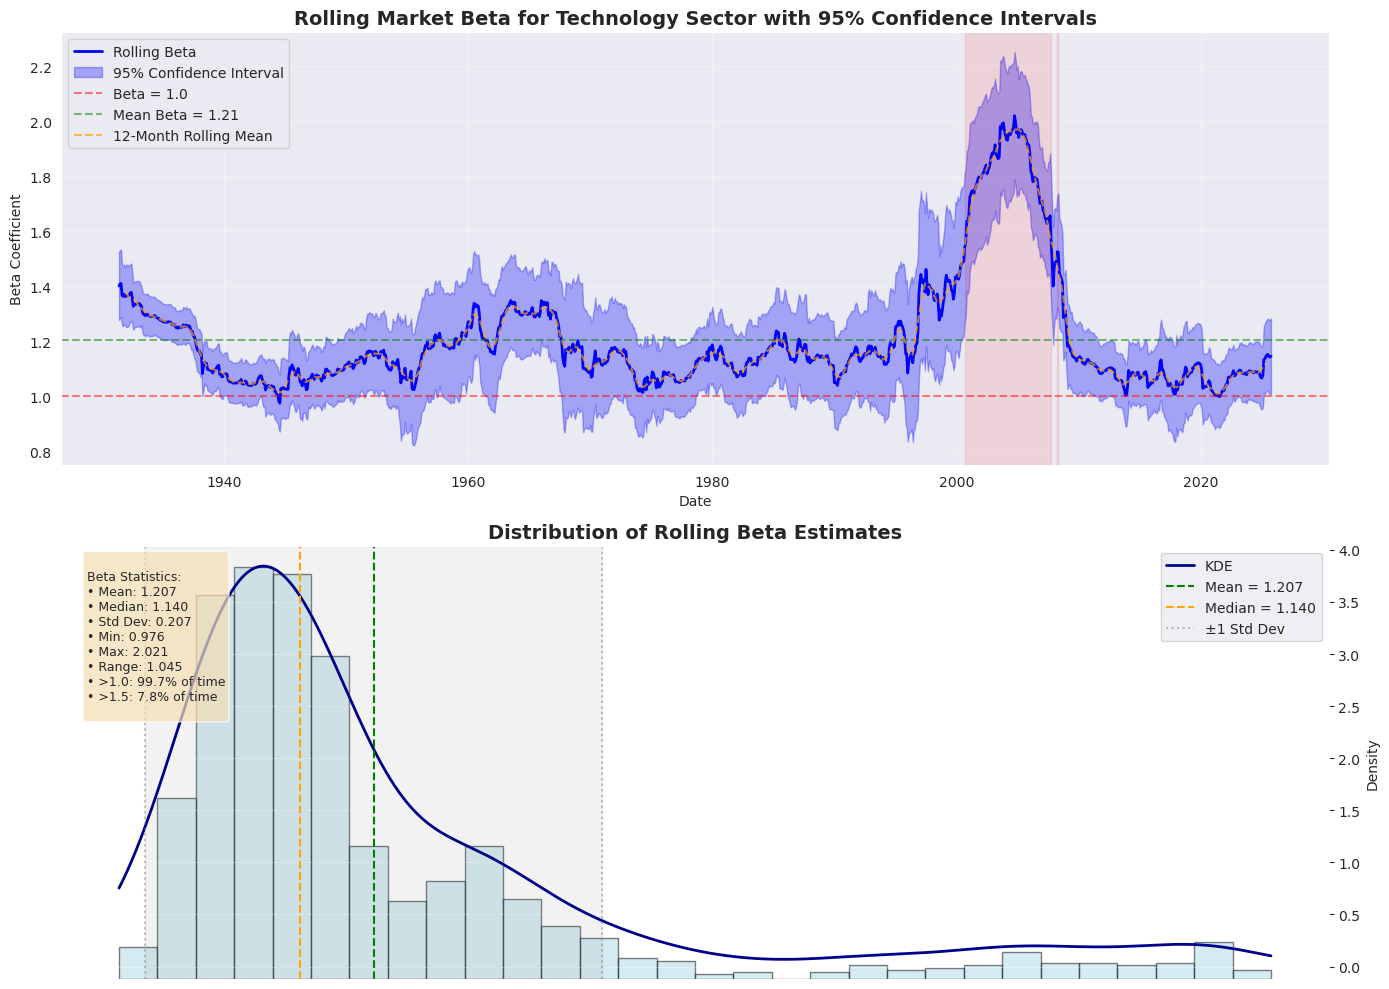


BETA DISTRIBUTION INSIGHTS
Beta exceeds 1.0 in 99.7% of periods
Beta exceeds 1.5 in 7.8% of periods
Beta exceeds 2.0 in 0.1% of periods
Beta below 1.0 in 0.3% of periods
Beta below 0.5 in 0.0% of periods

Confidence Interval Statistics:
Average CI width: 0.3094
Minimum CI width: 0.1209
Maximum CI width: 0.6154
Std Dev of CI width: 0.1093


In [8]:
# Create comprehensive visualization of rolling beta
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Rolling beta with confidence intervals
ax1 = axes[0]
beta_series = params['Beta (Market)'][window-1:]

# Convert Period index to datetime for proper plotting
dates = factors.index[window-1:].to_timestamp()

# Get confidence intervals - returns DataFrame with MultiIndex columns
conf_int = rres.conf_int(alpha=0.05)[window-1:]

# Debug: Print the structure of conf_int
print("Confidence interval structure:")
print(f"Type: {type(conf_int)}")
print(f"Shape: {conf_int.shape}")
print(f"Column MultiIndex: {conf_int.columns}")
print(f"\nFirst few rows of conf_int DataFrame:")
print(conf_int.head())

# Extract lower and upper bounds for Mkt-RF coefficient
# conf_int has MultiIndex columns: (parameter, bound_type)
# We need to access ('Mkt-RF', 'lower') and ('Mkt-RF', 'upper')
lower_bound = conf_int[('Mkt-RF', 'lower')]
upper_bound = conf_int[('Mkt-RF', 'upper')]

print(f"\nLower bound shape: {lower_bound.shape}")
print(f"Upper bound shape: {upper_bound.shape}")
print(f"Beta series shape: {beta_series.shape}")
print(f"Dates shape: {len(dates)}")

# Verify alignment of indices
print(f"\nIndex alignment check:")
print(f"Lower bound index first: {lower_bound.index[0]}")
print(f"Upper bound index first: {upper_bound.index[0]}")
print(f"Beta series index first: {beta_series.index[0]}")
print(f"Dates index first: {dates[0]}")

# Plot beta estimate with confidence intervals
ax1.plot(dates, beta_series, label='Rolling Beta', color='blue', linewidth=2)

# Fill between confidence intervals
ax1.fill_between(dates, 
                 lower_bound.values,  # Use .values to get numpy array
                 upper_bound.values, 
                 alpha=0.3, 
                 color='blue',
                 label='95% Confidence Interval')

# Add reference lines
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Beta = 1.0')
ax1.axhline(y=beta_series.mean(), color='green', linestyle='--', alpha=0.5, 
            label=f'Mean Beta = {beta_series.mean():.2f}')

# Add rolling mean for trend visualization
rolling_mean_12m = beta_series.rolling(window=12, center=True).mean()
ax1.plot(dates, rolling_mean_12m, '--', color='orange', alpha=0.7, 
         label='12-Month Rolling Mean', linewidth=1.5)

# Configure plot
ax1.set_title('Rolling Market Beta for Technology Sector with 95% Confidence Intervals', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Beta Coefficient')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Add shaded regions for significant beta periods
# Highlight periods where beta > 1.5 (high market sensitivity)
high_beta_periods = beta_series > 1.5
if high_beta_periods.any():
    # Find contiguous regions of high beta
    from scipy import ndimage
    labeled_array, num_features = ndimage.label(high_beta_periods)
    
    for i in range(1, num_features + 1):
        region_mask = labeled_array == i
        region_dates = dates[region_mask]
        if len(region_dates) > 0:
            ax1.axvspan(region_dates[0], region_dates[-1], 
                       alpha=0.1, color='red', label='Beta > 1.5' if i == 1 else "")

# Plot 2: Beta distribution and histogram
ax2 = axes[1]

# Create twin axis for distribution plot
ax2_hist = ax2.twinx()

# Plot histogram of beta values
n, bins, patches = ax2.hist(beta_series.dropna(), bins=30, alpha=0.5, 
                            color='lightblue', edgecolor='black', density=True)

# Add Kernel Density Estimation (KDE) plot
from scipy import stats
kde = stats.gaussian_kde(beta_series.dropna())
x_range = np.linspace(beta_series.min(), beta_series.max(), 1000)
ax2_hist.plot(x_range, kde(x_range), color='darkblue', linewidth=2, label='KDE')

# Add vertical lines for statistical measures
ax2_hist.axvline(x=beta_series.mean(), color='green', linestyle='--', 
                 label=f'Mean = {beta_series.mean():.3f}')
ax2_hist.axvline(x=beta_series.median(), color='orange', linestyle='--', 
                 label=f'Median = {beta_series.median():.3f}')
ax2_hist.axvline(x=beta_series.mean() + beta_series.std(), color='gray', 
                 linestyle=':', alpha=0.5, label=f'±1 Std Dev')
ax2_hist.axvline(x=beta_series.mean() - beta_series.std(), color='gray', 
                 linestyle=':', alpha=0.5)

# Add shaded region for ±1 standard deviation
ax2_hist.axvspan(beta_series.mean() - beta_series.std(), 
                 beta_series.mean() + beta_series.std(), 
                 alpha=0.1, color='gray')

# Configure distribution plot
ax2_hist.set_title('Distribution of Rolling Beta Estimates', fontsize=14, fontweight='bold')
ax2_hist.set_xlabel('Beta Value')
ax2_hist.set_ylabel('Density')
ax2_hist.legend(loc='upper right', fontsize=10)
ax2_hist.grid(True, alpha=0.3)

# Hide the empty subplot
ax2.axis('off')

# Add summary statistics as text box
stats_text = f"""
Beta Statistics:
• Mean: {beta_series.mean():.3f}
• Median: {beta_series.median():.3f}
• Std Dev: {beta_series.std():.3f}
• Min: {beta_series.min():.3f}
• Max: {beta_series.max():.3f}
• Range: {beta_series.max() - beta_series.min():.3f}
• >1.0: {(beta_series > 1.0).mean()*100:.1f}% of time
• >1.5: {(beta_series > 1.5).mean()*100:.1f}% of time
"""

ax2_hist.text(0.02, 0.98, stats_text, transform=ax2_hist.transAxes,
              fontsize=9, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()

# Print additional statistical insights
print("\n" + "="*60)
print("BETA DISTRIBUTION INSIGHTS")
print("="*60)
print(f"Beta exceeds 1.0 in {(beta_series > 1.0).mean()*100:.1f}% of periods")
print(f"Beta exceeds 1.5 in {(beta_series > 1.5).mean()*100:.1f}% of periods")
print(f"Beta exceeds 2.0 in {(beta_series > 2.0).mean()*100:.1f}% of periods")
print(f"Beta below 1.0 in {(beta_series < 1.0).mean()*100:.1f}% of periods")
print(f"Beta below 0.5 in {(beta_series < 0.5).mean()*100:.1f}% of periods")

# Calculate confidence interval width statistics
ci_width = upper_bound - lower_bound
print(f"\nConfidence Interval Statistics:")
print(f"Average CI width: {ci_width.mean():.4f}")
print(f"Minimum CI width: {ci_width.min():.4f}")
print(f"Maximum CI width: {ci_width.max():.4f}")
print(f"Std Dev of CI width: {ci_width.std():.4f}")

## 5.2 Alpha (Intercept) Analysis

Confidence interval structure for alpha:
Columns: MultiIndex([( 'const', 'lower'),
            ( 'const', 'upper'),
            ('Mkt-RF', 'lower'),
            ('Mkt-RF', 'upper')],
           )
Shape: (1133, 4)

Lower alpha bounds shape: (1133,)
Upper alpha bounds shape: (1133,)

Significantly positive periods: 67 (5.9%)
Significantly negative periods: 29 (2.6%)


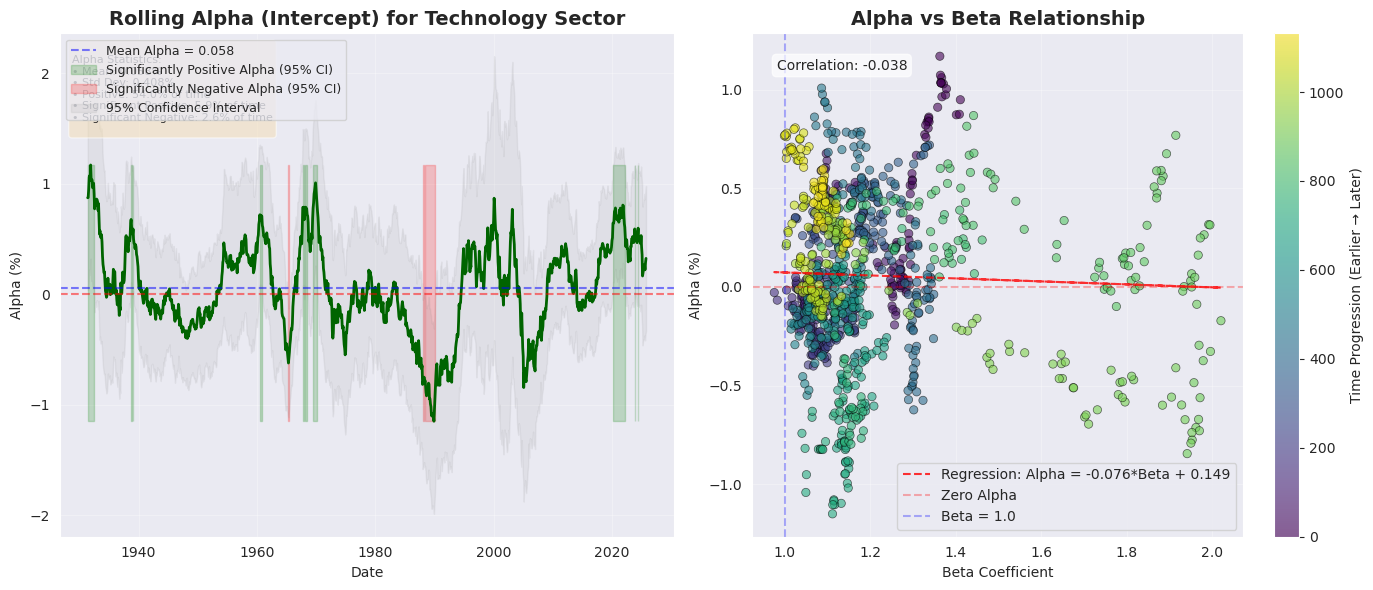


ALPHA-BETA RELATIONSHIP ANALYSIS
Correlation between alpha and beta: -0.038
Regression slope: -0.076
Regression intercept: 0.149

When beta = 1.0, predicted alpha = 0.074
When beta = 1.5, predicted alpha = 0.036
When beta = 2.0, predicted alpha = -0.002

Quadrant Analysis:
High Beta & High Alpha: 27.3%
High Beta & Low Alpha: 22.7%
Low Beta & High Alpha: 22.7%
Low Beta & Low Alpha: 27.4%


In [9]:
# Analyze rolling alpha estimates
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Time series of alpha
ax1 = axes[0]
alpha_series = params['Alpha (Intercept)'][window-1:]

ax1.plot(dates, alpha_series, color='darkgreen', linewidth=2)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.axhline(y=alpha_series.mean(), color='blue', linestyle='--', alpha=0.5,
            label=f'Mean Alpha = {alpha_series.mean():.3f}')

# Shade periods where alpha is significantly positive/negative
# Get confidence intervals for alpha (const parameter)
conf_int_df = rres.conf_int(alpha=0.05)[window-1:]

# Debug: Check the structure
print("Confidence interval structure for alpha:")
print(f"Columns: {conf_int_df.columns}")
print(f"Shape: {conf_int_df.shape}")

# Extract lower and upper bounds for const (alpha) parameter
# Using MultiIndex access: ('const', 'lower') and ('const', 'upper')
lower_alpha = conf_int_df[('const', 'lower')]
upper_alpha = conf_int_df[('const', 'upper')]

# Alternative way if MultiIndex causes issues:
# lower_alpha = conf_int_df.xs(('const', 'lower'), axis=1)
# upper_alpha = conf_int_df.xs(('const', 'upper'), axis=1)

print(f"\nLower alpha bounds shape: {lower_alpha.shape}")
print(f"Upper alpha bounds shape: {upper_alpha.shape}")

# Determine where alpha is significantly positive/negative
# Alpha is significantly positive if lower bound > 0
positive_alpha = lower_alpha > 0

# Alpha is significantly negative if upper bound < 0
negative_alpha = upper_alpha < 0

print(f"\nSignificantly positive periods: {positive_alpha.sum()} ({positive_alpha.mean()*100:.1f}%)")
print(f"Significantly negative periods: {negative_alpha.sum()} ({negative_alpha.mean()*100:.1f}%)")

# Shade significantly positive alpha periods
if positive_alpha.any():
    ax1.fill_between(dates, 
                     alpha_series.min(), 
                     alpha_series.max(), 
                     where=positive_alpha, 
                     alpha=0.2, 
                     color='green',
                     label='Significantly Positive Alpha (95% CI)')

# Shade significantly negative alpha periods  
if negative_alpha.any():
    ax1.fill_between(dates, 
                     alpha_series.min(), 
                     alpha_series.max(),
                     where=negative_alpha, 
                     alpha=0.2, 
                     color='red',
                     label='Significantly Negative Alpha (95% CI)')

# Add confidence interval bands for alpha
ax1.fill_between(dates,
                 lower_alpha,
                 upper_alpha,
                 alpha=0.1,
                 color='gray',
                 label='95% Confidence Interval')

ax1.set_title('Rolling Alpha (Intercept) for Technology Sector', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Alpha (%)')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Add statistics annotation
alpha_stats_text = f"""
Alpha Statistics:
• Mean: {alpha_series.mean():.3f}%
• Std Dev: {alpha_series.std():.3f}%
• Positive: {(alpha_series > 0).mean()*100:.1f}% of time
• Significant Positive: {positive_alpha.mean()*100:.1f}% of time
• Significant Negative: {negative_alpha.mean()*100:.1f}% of time
"""

ax1.text(0.02, 0.98, alpha_stats_text, transform=ax1.transAxes,
         fontsize=8, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Alpha vs Beta scatter plot
ax2 = axes[1]
scatter = ax2.scatter(beta_series, alpha_series, c=range(len(beta_series)), 
                      cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)

# Add regression line
z = np.polyfit(beta_series, alpha_series, 1)
p = np.poly1d(z)
ax2.plot(beta_series, p(beta_series), "r--", alpha=0.8, 
         label=f'Regression: Alpha = {z[0]:.3f}*Beta + {z[1]:.3f}')

ax2.axhline(y=0, color='red', linestyle='--', alpha=0.3, label='Zero Alpha')
ax2.axvline(x=1, color='blue', linestyle='--', alpha=0.3, label='Beta = 1.0')

# Add correlation coefficient
correlation = np.corrcoef(beta_series, alpha_series)[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax2.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax2.set_title('Alpha vs Beta Relationship', fontsize=14, fontweight='bold')
ax2.set_xlabel('Beta Coefficient')
ax2.set_ylabel('Alpha (%)')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Add colorbar for time
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Time Progression (Earlier → Later)')

plt.tight_layout()
plt.show()

# Print additional insights about alpha-beta relationship
print("\n" + "="*60)
print("ALPHA-BETA RELATIONSHIP ANALYSIS")
print("="*60)
print(f"Correlation between alpha and beta: {correlation:.3f}")
print(f"Regression slope: {z[0]:.3f}")
print(f"Regression intercept: {z[1]:.3f}")
print(f"\nWhen beta = 1.0, predicted alpha = {p(1.0):.3f}")
print(f"When beta = 1.5, predicted alpha = {p(1.5):.3f}")
print(f"When beta = 2.0, predicted alpha = {p(2.0):.3f}")

# Analyze quadrants
high_beta = beta_series > beta_series.median()
high_alpha = alpha_series > alpha_series.median()

print(f"\nQuadrant Analysis:")
print(f"High Beta & High Alpha: {((high_beta) & (high_alpha)).mean()*100:.1f}%")
print(f"High Beta & Low Alpha: {((high_beta) & (~high_alpha)).mean()*100:.1f}%")
print(f"Low Beta & High Alpha: {((~high_beta) & (high_alpha)).mean()*100:.1f}%")
print(f"Low Beta & Low Alpha: {((~high_beta) & (~high_alpha)).mean()*100:.1f}%")

# 6. Advanced Rolling Regression Analysis
## 6.1 Multiple Factor Model (Fama-French 3 Factor)

In [10]:
# Prepare data for 3-factor model
tech_excess = industries['HiTec'] - factors['RF'].values
X_3factor = sm.add_constant(factors[['Mkt-RF', 'SMB', 'HML']])

# Rolling regression with 3 factors
rols_3factor = RollingOLS(tech_excess, X_3factor, window=window)
rres_3factor = rols_3factor.fit()

# Extract parameters
params_3factor = rres_3factor.params.copy()
params_3factor.columns = ['Alpha', 'Market Beta', 'SMB Beta', 'HML Beta']
params_3factor.index = np.arange(1, params_3factor.shape[0] + 1)

print("Three-Factor Model Results:")
print("=" * 50)

# Display summary statistics
print("\nAverage Rolling Coefficients (excluding NaN):")
print(params_3factor[window-1:].mean())

print("\nCoefficient Volatility (Standard Deviation):")
print(params_3factor[window-1:].std())

print("\nCorrelation between Factor Betas:")
print(params_3factor[['Market Beta', 'SMB Beta', 'HML Beta']][window-1:].corr())

Three-Factor Model Results:

Average Rolling Coefficients (excluding NaN):
Alpha          0.202968
Market Beta    1.144387
SMB Beta       0.101572
HML Beta      -0.466376
dtype: float64

Coefficient Volatility (Standard Deviation):
Alpha          0.374730
Market Beta    0.160715
SMB Beta       0.204740
HML Beta       0.310182
dtype: float64

Correlation between Factor Betas:
             Market Beta  SMB Beta  HML Beta
Market Beta     1.000000 -0.211208 -0.016286
SMB Beta       -0.211208  1.000000 -0.106699
HML Beta       -0.016286 -0.106699  1.000000


The technology sector maintains strong positive market exposure with an average beta of 1.14, confirming its high-risk, high-reward characteristics consistent with CAPM findings. Surprisingly, the sector shows negative exposure to the value factor (average HML beta of -0.47), indicating technology stocks behave more like growth stocks than value stocks, which aligns with the sector's innovation-focused nature. The moderate positive exposure to the size factor (average SMB beta of 0.10) suggests technology stocks have some small-cap characteristics, though this effect is relatively weak compared to market exposure. The low correlations between factor betas (-0.21 to -0.11) indicate these factors capture distinct risk dimensions, while the substantial coefficient volatility (especially for HML beta at 0.31) highlights the time-varying nature of these risk exposures in the technology sector.

## 6.2 Visualization of Multiple Factors

Debug - Available columns in confidence intervals:
Columns: MultiIndex([( 'const', 'lower'),
            ( 'const', 'upper'),
            ('Mkt-RF', 'lower'),
            ('Mkt-RF', 'upper'),
            (   'SMB', 'lower'),
            (   'SMB', 'upper'),
            (   'HML', 'lower'),
            (   'HML', 'upper')],
           )
Looking for parameter: 'Mkt-RF'


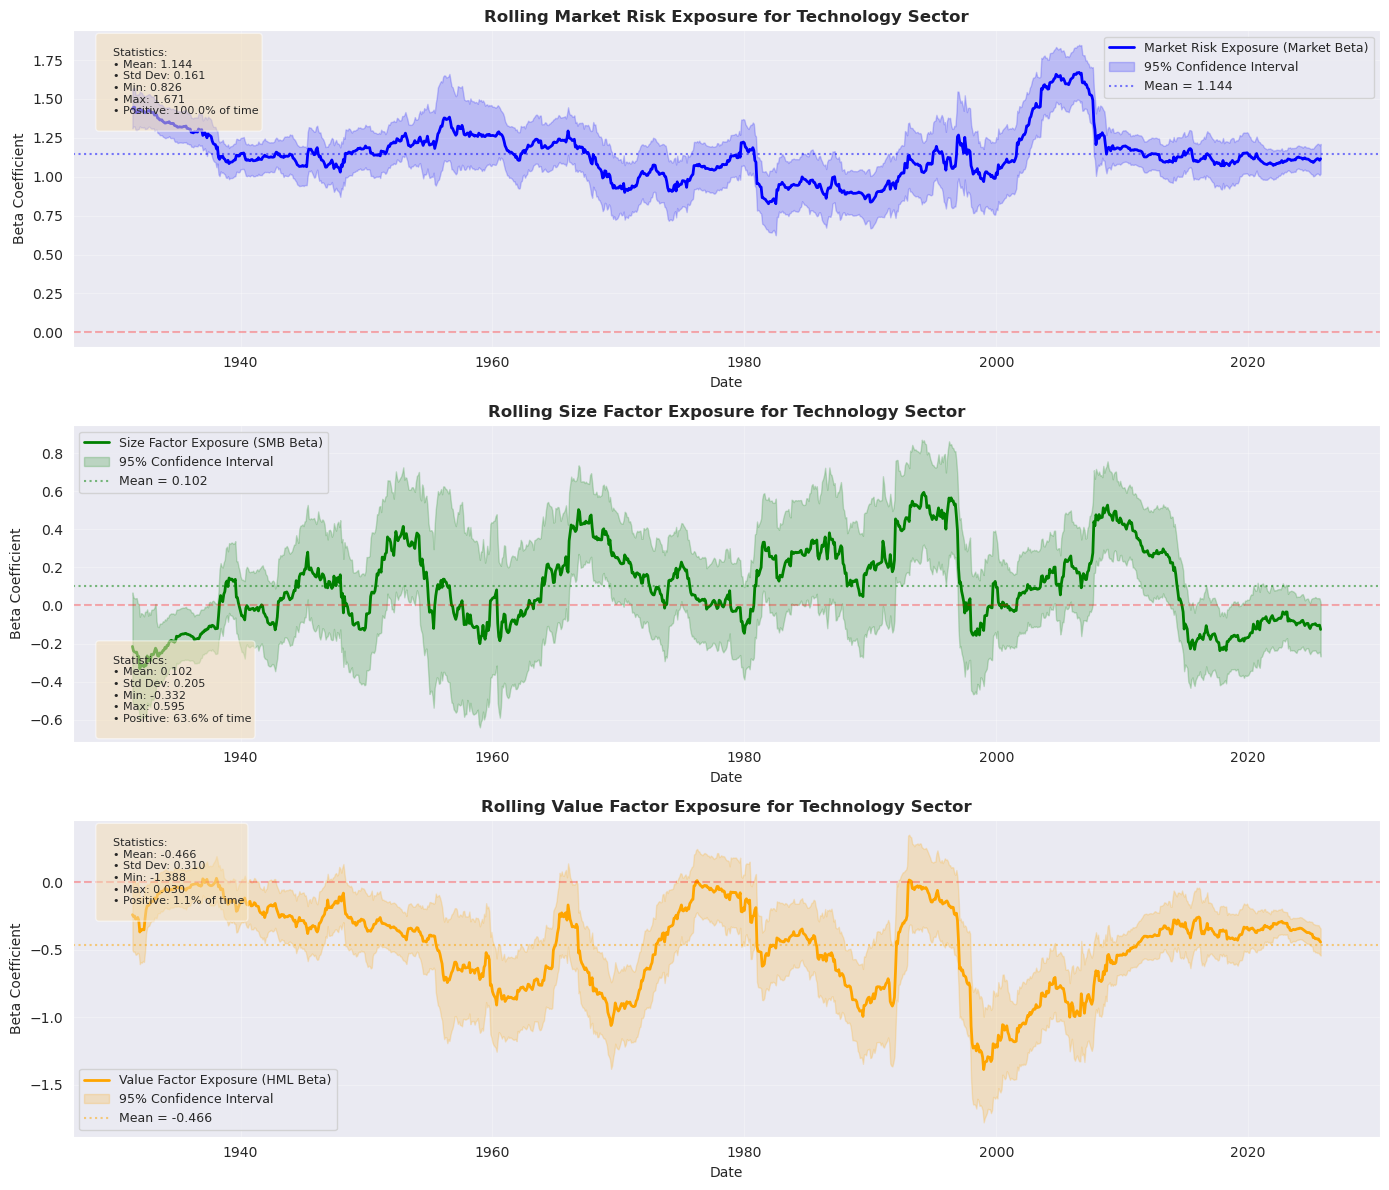


CONFIDENCE INTERVAL WIDTH ANALYSIS

Market Beta (Mkt-RF):
  Average CI width: 0.3125
  Minimum CI width: 0.1368
  Maximum CI width: 0.6065
  Precision (1/width): 3.2

SMB Beta (SMB):
  Average CI width: 0.5139
  Minimum CI width: 0.2280
  Maximum CI width: 1.0559
  Precision (1/width): 1.9

HML Beta (HML):
  Average CI width: 0.5026
  Minimum CI width: 0.1618
  Maximum CI width: 0.9217
  Precision (1/width): 2.0

FACTOR SIGNIFICANCE ANALYSIS

Market Beta:
  Significantly Positive: 100.0% of time
  Significantly Negative: 0.0% of time
  Not Significant: 0.0% of time

SMB Beta:
  Significantly Positive: 23.2% of time
  Significantly Negative: 7.4% of time
  Not Significant: 69.4% of time

HML Beta:
  Significantly Positive: 0.0% of time
  Significantly Negative: 76.1% of time
  Not Significant: 23.9% of time


In [11]:
# Plot all three factor betas
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Define mapping between display names and original parameter names
# params_3factor has renamed columns, but conf_int uses original parameter names
factor_mapping = {
    'Market Beta': 'Mkt-RF',  # Original parameter name from Fama-French
    'SMB Beta': 'SMB',        # Original parameter name
    'HML Beta': 'HML'         # Original parameter name
}

colors = ['blue', 'green', 'orange']
titles = ['Market Risk Exposure', 'Size Factor Exposure', 'Value Factor Exposure']

for idx, (display_name, color, title) in enumerate(zip(factor_mapping.keys(), colors, titles)):
    ax = axes[idx]
    
    # Get the beta series using display name
    factor_series = params_3factor[display_name][window-1:]
    
    # Get original parameter name for confidence interval access
    original_param = factor_mapping[display_name]
    
    # Plot factor beta
    ax.plot(dates, factor_series, color=color, linewidth=2, label=f'{title} ({display_name})')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
    
    # DEBUG: Check available columns in confidence intervals
    if idx == 0:  # Only print debug info for first factor
        conf_int_all = rres_3factor.conf_int(alpha=0.05)[window-1:]
        print("Debug - Available columns in confidence intervals:")
        print(f"Columns: {conf_int_all.columns}")
        print(f"Looking for parameter: '{original_param}'")
    
    # Get confidence intervals - using original parameter names
    conf_int_df = rres_3factor.conf_int(alpha=0.05)[window-1:]
    
    # Extract lower and upper bounds using MultiIndex
    # Format: (parameter_name, 'lower') and (parameter_name, 'upper')
    lower_bound = conf_int_df[(original_param, 'lower')]
    upper_bound = conf_int_df[(original_param, 'upper')]
    
    # Alternative approach if MultiIndex access fails:
    # lower_bound = conf_int_df.xs((original_param, 'lower'), axis=1)
    # upper_bound = conf_int_df.xs((original_param, 'upper'), axis=1)
    
    # Add confidence intervals to plot
    ax.fill_between(dates, 
                    lower_bound.values, 
                    upper_bound.values, 
                    alpha=0.2, 
                    color=color,
                    label='95% Confidence Interval')
    
    # Add horizontal line at mean value
    ax.axhline(y=factor_series.mean(), color=color, linestyle=':', alpha=0.5,
               label=f'Mean = {factor_series.mean():.3f}')
    
    # Configure plot
    ax.set_title(f'Rolling {title} for Technology Sector', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Beta Coefficient')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add statistics annotation
    stats_text = f"""
    Statistics:
    • Mean: {factor_series.mean():.3f}
    • Std Dev: {factor_series.std():.3f}
    • Min: {factor_series.min():.3f}
    • Max: {factor_series.max():.3f}
    • Positive: {(factor_series > 0).mean()*100:.1f}% of time
    """
    
    # Position annotation based on factor
    if display_name == 'Market Beta':
        bbox_pos = (0.02, 0.98)  # Upper left
    elif display_name == 'SMB Beta':
        bbox_pos = (0.02, 0.02)  # Lower left
    else:  # HML Beta
        bbox_pos = (0.02, 0.98)  # Upper left
    
    ax.text(bbox_pos[0], bbox_pos[1], stats_text, transform=ax.transAxes,
            fontsize=8, verticalalignment='top' if bbox_pos[1] > 0.5 else 'bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary of confidence interval widths
print("\n" + "="*60)
print("CONFIDENCE INTERVAL WIDTH ANALYSIS")
print("="*60)

conf_int_all = rres_3factor.conf_int(alpha=0.05)[window-1:]

for display_name, original_param in factor_mapping.items():
    lower = conf_int_all[(original_param, 'lower')]
    upper = conf_int_all[(original_param, 'upper')]
    ci_width = upper - lower
    
    print(f"\n{display_name} ({original_param}):")
    print(f"  Average CI width: {ci_width.mean():.4f}")
    print(f"  Minimum CI width: {ci_width.min():.4f}")
    print(f"  Maximum CI width: {ci_width.max():.4f}")
    print(f"  Precision (1/width): {1/ci_width.mean():.1f}")

# Calculate proportion of time each factor is significant
print("\n" + "="*60)
print("FACTOR SIGNIFICANCE ANALYSIS")
print("="*60)

for display_name, original_param in factor_mapping.items():
    lower = conf_int_all[(original_param, 'lower')]
    upper = conf_int_all[(original_param, 'upper')]
    
    # Factor is significantly positive if lower bound > 0
    sig_positive = (lower > 0).mean() * 100
    
    # Factor is significantly negative if upper bound < 0
    sig_negative = (upper < 0).mean() * 100
    
    # Factor is not significant if CI includes 0
    not_sig = 100 - sig_positive - sig_negative
    
    print(f"\n{display_name}:")
    print(f"  Significantly Positive: {sig_positive:.1f}% of time")
    print(f"  Significantly Negative: {sig_negative:.1f}% of time")
    print(f"  Not Significant: {not_sig:.1f}% of time")

## 6.3 R-squared Analysis

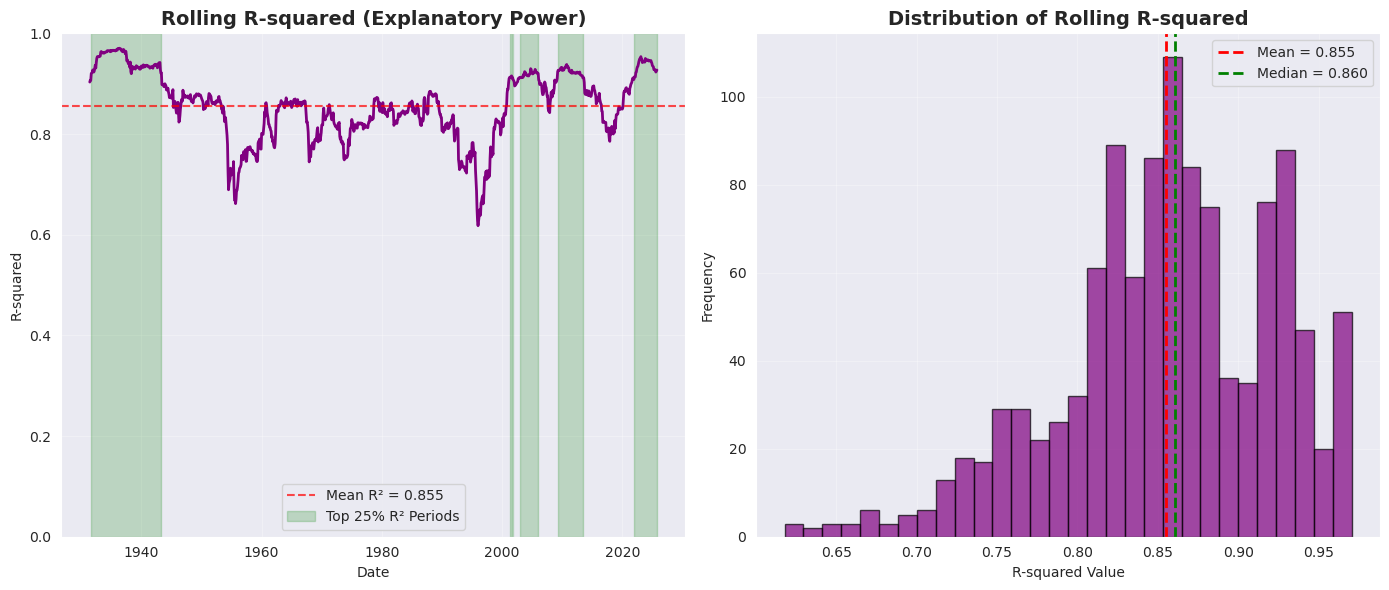

R-squared Analysis:
Mean R-squared: 0.8552
Median R-squared: 0.8604
Std Dev of R-squared: 0.0671
Minimum R-squared: 0.6179
Maximum R-squared: 0.9705

Percentage of time R-squared > 0.5: 100.0%
Percentage of time R-squared > 0.7: 97.8%


In [12]:
# Calculate rolling R-squared
rsquared = rres_3factor.rsquared[window-1:]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Time series of R-squared
ax1 = axes[0]
ax1.plot(dates, rsquared, color='purple', linewidth=2)
ax1.axhline(y=rsquared.mean(), color='red', linestyle='--', alpha=0.7,
            label=f'Mean R² = {rsquared.mean():.3f}')

# Highlight periods of high explanatory power
high_rsquared = rsquared > rsquared.quantile(0.75)
ax1.fill_between(dates, 0, 1, where=high_rsquared, alpha=0.2, color='green',
                 label='Top 25% R² Periods')

ax1.set_title('Rolling R-squared (Explanatory Power)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('R-squared')
ax1.set_ylim([0, 1])
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution of R-squared
ax2 = axes[1]
ax2.hist(rsquared, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax2.axvline(x=rsquared.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean = {rsquared.mean():.3f}')
ax2.axvline(x=rsquared.median(), color='green', linestyle='--', linewidth=2,
            label=f'Median = {rsquared.median():.3f}')

ax2.set_title('Distribution of Rolling R-squared', fontsize=14, fontweight='bold')
ax2.set_xlabel('R-squared Value')
ax2.set_ylabel('Frequency')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of model fit
print("R-squared Analysis:")
print("=" * 50)
print(f"Mean R-squared: {rsquared.mean():.4f}")
print(f"Median R-squared: {rsquared.median():.4f}")
print(f"Std Dev of R-squared: {rsquared.std():.4f}")
print(f"Minimum R-squared: {rsquared.min():.4f}")
print(f"Maximum R-squared: {rsquared.max():.4f}")
print(f"\nPercentage of time R-squared > 0.5: {(rsquared > 0.5).mean() * 100:.1f}%")
print(f"Percentage of time R-squared > 0.7: {(rsquared > 0.7).mean() * 100:.1f}%")

# 7. Comparative Analysis Across Industries
## 7.1 Rolling Beta Comparison

Debug for HiTec sector:
Confidence interval columns: MultiIndex([( 'const', 'lower'),
            ( 'const', 'upper'),
            ('Mkt-RF', 'lower'),
            ('Mkt-RF', 'upper')],
           )
Confidence interval shape: (1133, 4)


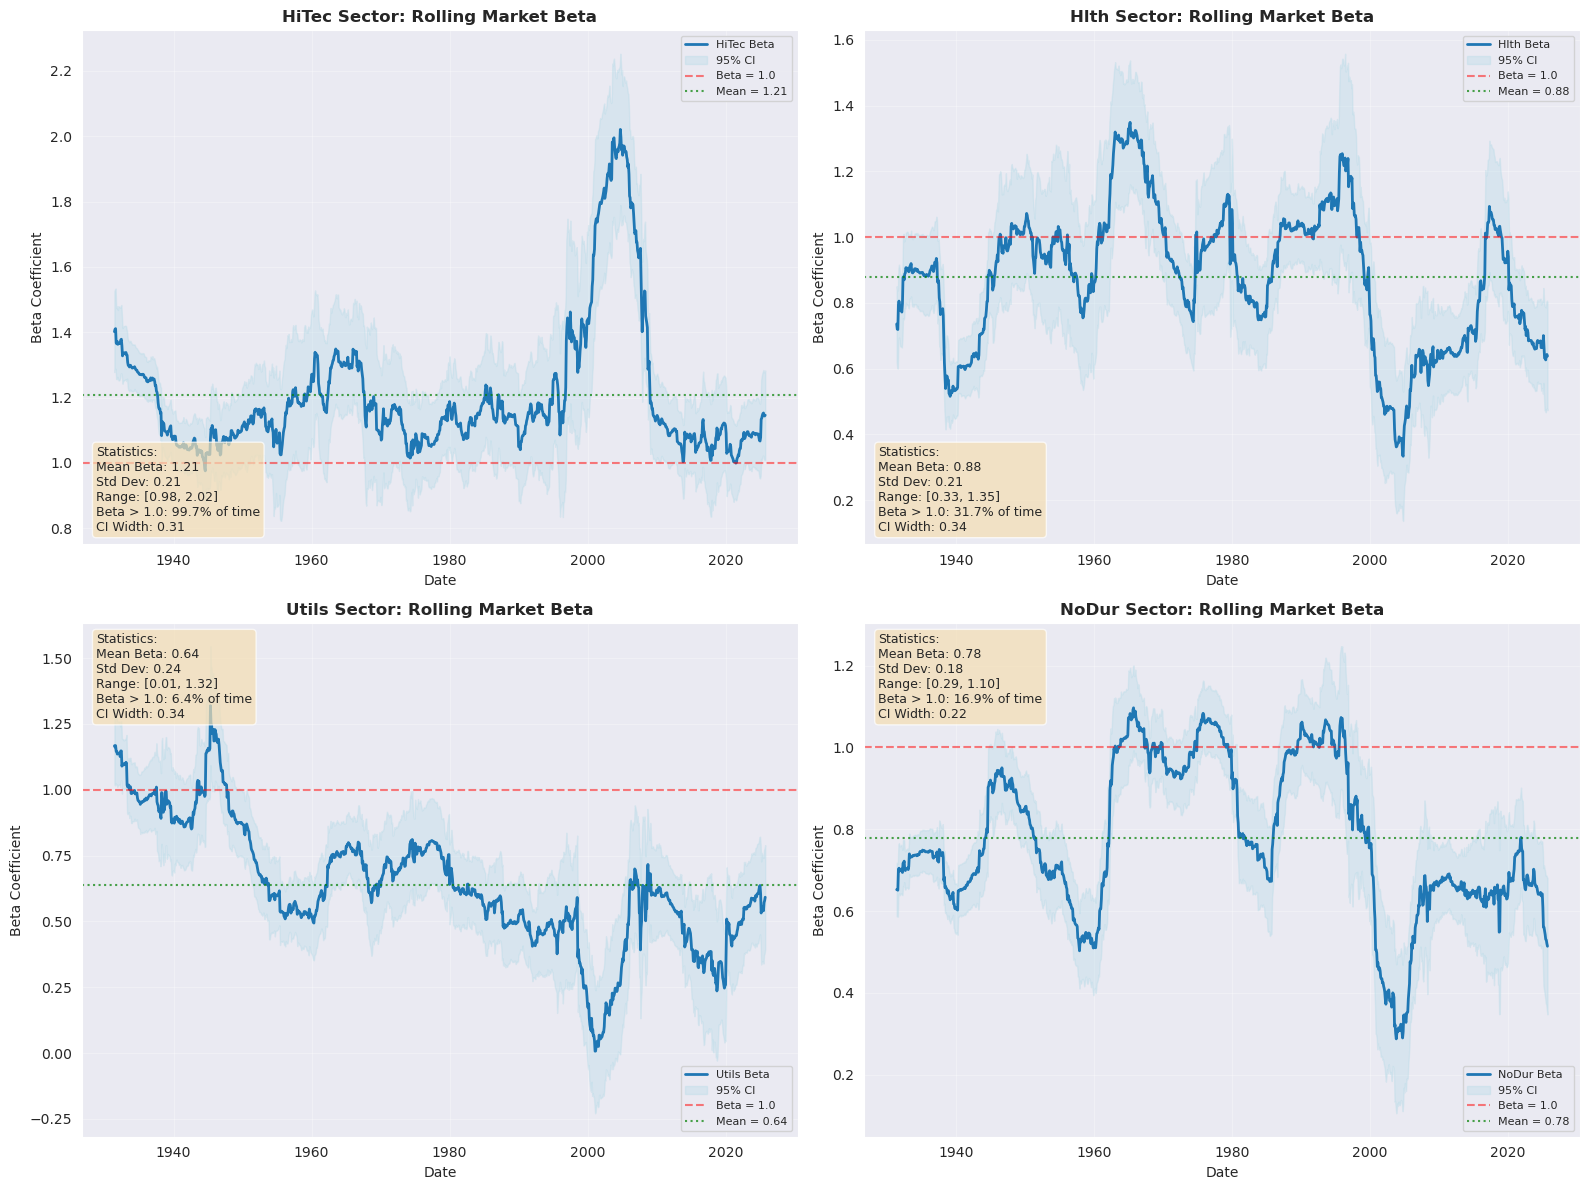


INDUSTRY BETA COMPARATIVE ANALYSIS

Comparative Beta Statistics:
Industry  Mean Beta  Beta Volatility  CI Width  Beta > 1.0 (%) Risk Category
   HiTec   1.206695         0.207083  0.309429       99.735216          High
    Hlth   0.878732         0.207889  0.341146       31.685790        Medium
   Utils   0.638228         0.236129  0.339473        6.443071           Low
   NoDur   0.778038         0.184823  0.221714       16.946161           Low

----------------------------------------------------------------------
INDUSTRY RANKING BY MARKET RISK:
----------------------------------------------------------------------
1. HiTec: Mean Beta = 1.21 (High Risk)
2. Hlth: Mean Beta = 0.88 (Medium Risk)
3. NoDur: Mean Beta = 0.78 (Low Risk)
4. Utils: Mean Beta = 0.64 (Low Risk)

----------------------------------------------------------------------
BETA CORRELATIONS BETWEEN INDUSTRIES:
----------------------------------------------------------------------

Correlation Matrix of Rolling Betas:

In [13]:
# Select a subset of industries for comparison
selected_industries = ['HiTec', 'Hlth', 'Utils', 'NoDur']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, industry in enumerate(selected_industries):
    ax = axes[idx]
    
    # Calculate excess returns for the industry
    industry_excess = industries[industry] - factors['RF'].values
    
    # Fit rolling regression for this industry
    rols_ind = RollingOLS(industry_excess, X, window=window)
    rres_ind = rols_ind.fit()
    params_ind = rres_ind.params.copy()
    
    # Extract beta series (excluding NaN values from window initialization)
    beta_ind = params_ind['Mkt-RF'][window-1:]
    
    # Plot beta series
    ax.plot(dates, beta_ind, linewidth=2, label=f'{industry} Beta')
    
    # Get confidence intervals - returns DataFrame with MultiIndex columns
    conf_int_df = rres_ind.conf_int(alpha=0.05)[window-1:]
    
    # Debug: Check structure for first industry
    if idx == 0:
        print(f"Debug for {industry} sector:")
        print(f"Confidence interval columns: {conf_int_df.columns}")
        print(f"Confidence interval shape: {conf_int_df.shape}")
    
    # Extract lower and upper bounds for Mkt-RF parameter
    # Using MultiIndex access: ('Mkt-RF', 'lower') and ('Mkt-RF', 'upper')
    lower_bound = conf_int_df[('Mkt-RF', 'lower')]
    upper_bound = conf_int_df[('Mkt-RF', 'upper')]
    
    # Add confidence intervals to plot
    ax.fill_between(dates, 
                    lower_bound.values,  # Convert to numpy array
                    upper_bound.values, 
                    alpha=0.3, 
                    color='lightblue',
                    label='95% CI')
    
    # Add reference line at beta = 1.0
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Beta = 1.0')
    
    # Add mean beta line
    mean_beta = beta_ind.mean()
    ax.axhline(y=mean_beta, color='green', linestyle=':', alpha=0.7, 
               label=f'Mean = {mean_beta:.2f}')
    
    # Configure plot
    ax.set_title(f'{industry} Sector: Rolling Market Beta', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Beta Coefficient')
    ax.grid(True, alpha=0.3)
    
    # Calculate additional statistics
    beta_std = beta_ind.std()
    beta_min = beta_ind.min()
    beta_max = beta_ind.max()
    above_one = (beta_ind > 1.0).mean() * 100
    
    # Add comprehensive statistics annotation
    stats_text = f"""Statistics:
Mean Beta: {mean_beta:.2f}
Std Dev: {beta_std:.2f}
Range: [{beta_min:.2f}, {beta_max:.2f}]
Beta > 1.0: {above_one:.1f}% of time
CI Width: {(upper_bound - lower_bound).mean():.2f}"""
    
    # Position annotation based on industry characteristics
    if industry in ['HiTec', 'Hlth']:  # Usually high beta
        bbox_pos = (0.02, 0.02)  # Lower left
        valign = 'bottom'
    else:  # Usually lower beta
        bbox_pos = (0.02, 0.98)  # Upper left
        valign = 'top'
    
    ax.text(bbox_pos[0], bbox_pos[1], stats_text, transform=ax.transAxes,
            fontsize=9, verticalalignment=valign,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Add legend
    ax.legend(loc='upper right' if industry in ['HiTec', 'Hlth'] else 'lower right', 
              fontsize=8)

plt.tight_layout()
plt.show()

# Print comparative analysis
print("\n" + "="*70)
print("INDUSTRY BETA COMPARATIVE ANALYSIS")
print("="*70)

comparison_data = []

for industry in selected_industries:
    # Recalculate for consistency (or reuse from loop)
    industry_excess = industries[industry] - factors['RF'].values
    rols_ind = RollingOLS(industry_excess, X, window=window)
    rres_ind = rols_ind.fit()
    params_ind = rres_ind.params.copy()
    
    beta_ind = params_ind['Mkt-RF'][window-1:]
    conf_int_df = rres_ind.conf_int(alpha=0.05)[window-1:]
    lower = conf_int_df[('Mkt-RF', 'lower')]
    upper = conf_int_df[('Mkt-RF', 'upper')]
    
    # Calculate statistics
    mean_beta = beta_ind.mean()
    std_beta = beta_ind.std()
    ci_width = (upper - lower).mean()
    above_one_pct = (beta_ind > 1.0).mean() * 100
    
    comparison_data.append({
        'Industry': industry,
        'Mean Beta': mean_beta,
        'Beta Volatility': std_beta,
        'CI Width': ci_width,
        'Beta > 1.0 (%)': above_one_pct,
        'Risk Category': 'High' if mean_beta > 1.2 else ('Medium' if mean_beta > 0.8 else 'Low')
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)
print("\nComparative Beta Statistics:")
print(comparison_df.to_string(index=False))

# Rank industries by beta
print("\n" + "-"*70)
print("INDUSTRY RANKING BY MARKET RISK:")
print("-"*70)
ranked = comparison_df.sort_values('Mean Beta', ascending=False)
for i, (_, row) in enumerate(ranked.iterrows(), 1):
    print(f"{i}. {row['Industry']}: Mean Beta = {row['Mean Beta']:.2f} ({row['Risk Category']} Risk)")

# Calculate correlation between industry betas
print("\n" + "-"*70)
print("BETA CORRELATIONS BETWEEN INDUSTRIES:")
print("-"*70)

# Collect all beta series
beta_series_dict = {}
for industry in selected_industries:
    industry_excess = industries[industry] - factors['RF'].values
    rols_ind = RollingOLS(industry_excess, X, window=window)
    rres_ind = rols_ind.fit()
    params_ind = rres_ind.params.copy()
    beta_series_dict[industry] = params_ind['Mkt-RF'][window-1:]

# Create correlation matrix
corr_matrix = pd.DataFrame({ind: beta_series_dict[ind] for ind in selected_industries}).corr()
print("\nCorrelation Matrix of Rolling Betas:")
print(corr_matrix.round(3))

## 7.2 Beta Distribution Comparison

Analyzing beta distributions for 10 industries...
  Processed 2/10 industries...
  Processed 4/10 industries...
  Processed 6/10 industries...
  Processed 8/10 industries...
  Processed 10/10 industries...
✓ All industries processed successfully!

MARKET BETA SUMMARY ACROSS ALL INDUSTRIES

Total industries analyzed: 10
Time period: 1133 months

Sorted by Mean Beta (Highest to Lowest):
--------------------------------------------------------------------------------
       Mean Beta  Beta Std Dev  Min Beta  Max Beta  Beta Range  % Beta > 1.0  \
HiTec      1.207         0.207     0.976     2.021       1.045        99.735   
Durbl      1.203         0.267     0.752     2.057       1.305        78.111   
Other      1.105         0.114     0.738     1.334       0.596        87.290   
Manuf      1.087         0.107     0.754     1.267       0.513        84.025   
Shops      0.957         0.154     0.597     1.253       0.656        31.333   
Enrgy      0.923         0.243     0.418     1.731 

/tmp/ipykernel_95395/3216730392.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax2.boxplot(beta_data, vert=False, labels=industries_sorted,


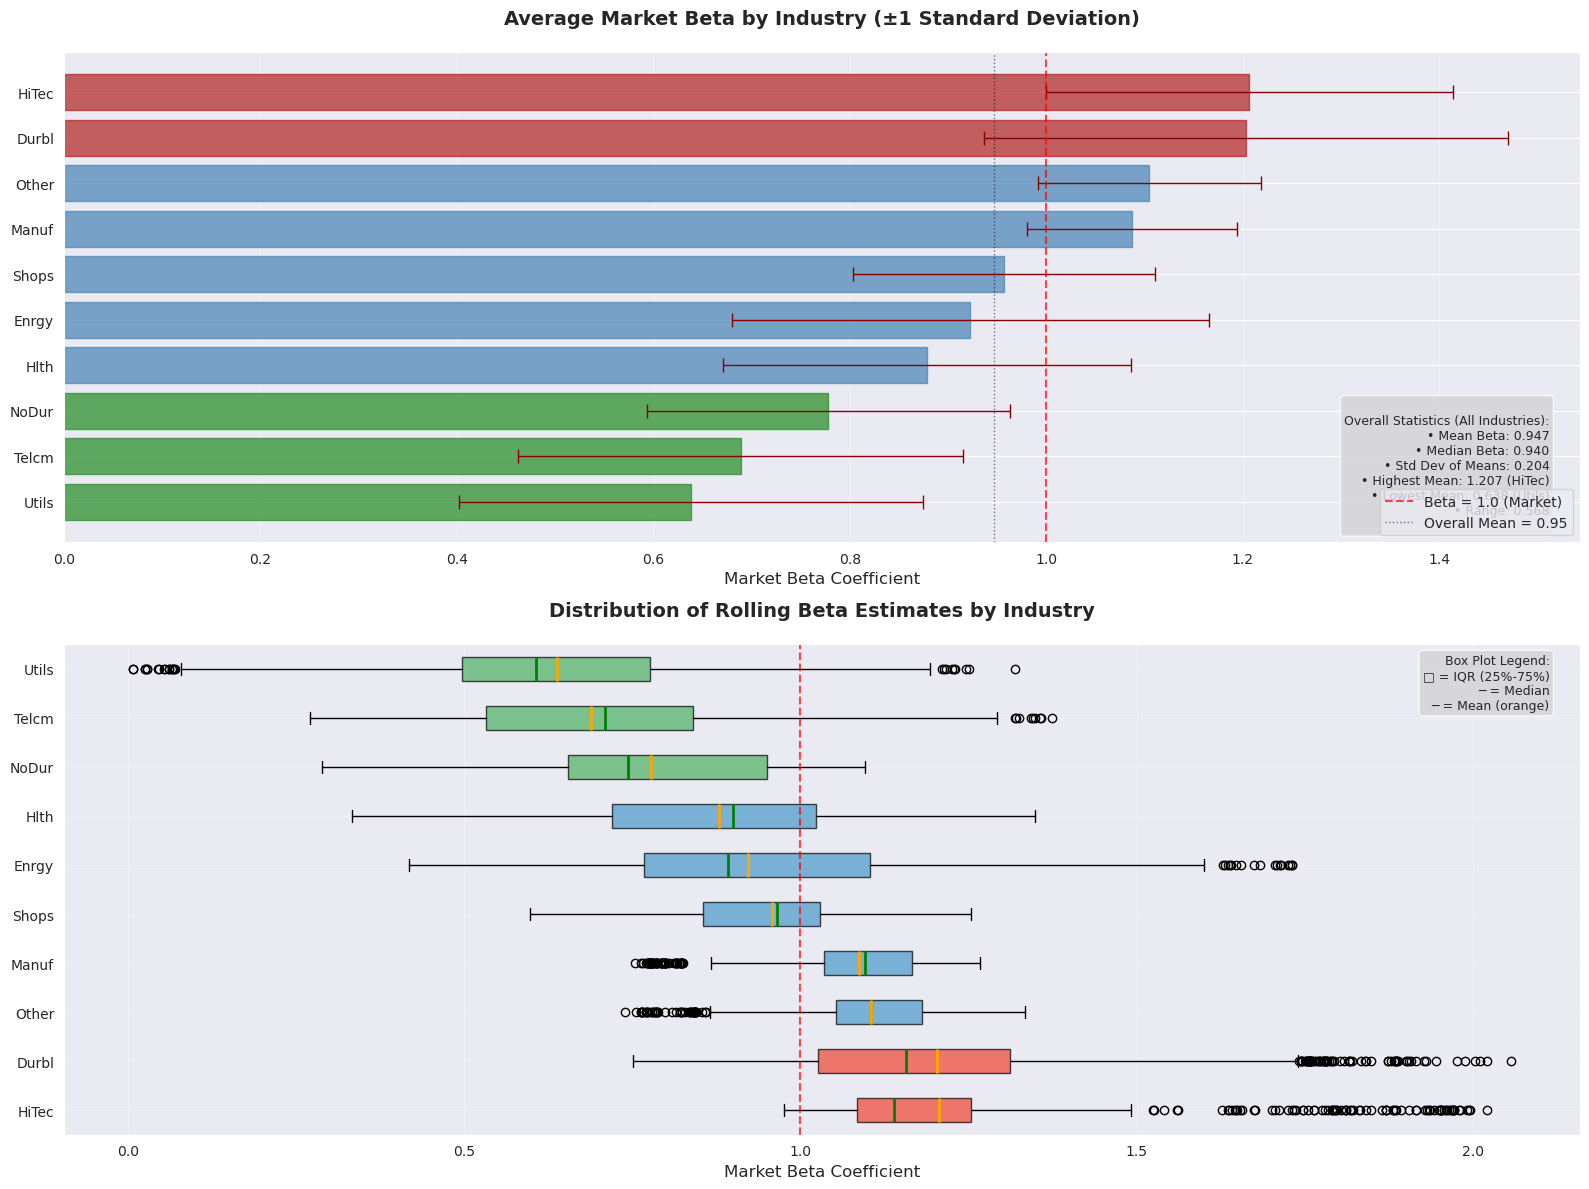


CROSS-INDUSTRY BETA CORRELATION ANALYSIS

Correlation matrix dimensions: (10, 10)

Most positively correlated industry pairs (Top 5):
1. NoDur & Hlth: 0.775
2. NoDur & Shops: 0.756
3. HiTec & Telcm: 0.539
4. NoDur & Other: 0.490
5. Manuf & Other: 0.472

Most negatively correlated industry pairs (Top 5):
1. Enrgy & Telcm: -0.503
2. Manuf & Telcm: -0.573
3. Enrgy & HiTec: -0.576
4. Manuf & HiTec: -0.632
5. HiTec & Other: -0.679

Average correlation between industry betas: 0.015
(Lower values suggest better diversification potential)


In [14]:
# Compare beta distributions across all industries
all_betas = {}

print(f"Analyzing beta distributions for {len(industries.columns)} industries...")

for idx, industry in enumerate(industries.columns, 1):
    # Calculate excess returns for each industry
    industry_excess = industries[industry] - factors['RF'].values
    
    # Fit rolling regression
    rols_ind = RollingOLS(industry_excess, X, window=window)
    rres_ind = rols_ind.fit()
    params_ind = rres_ind.params.copy()
    
    # Extract beta series (excluding NaN values from window initialization)
    beta_series = params_ind['Mkt-RF'][window-1:]
    
    # Store comprehensive beta statistics
    all_betas[industry] = {
        'mean': beta_series.mean(),
        'std': beta_series.std(),
        'min': beta_series.min(),
        'max': beta_series.max(),
        'range': beta_series.max() - beta_series.min(),
        'series': beta_series,
        'above_one_pct': (beta_series > 1.0).mean() * 100,
        'below_one_pct': (beta_series < 1.0).mean() * 100
    }
    
    # Progress indicator
    if idx % 2 == 0 or idx == len(industries.columns):
        print(f"  Processed {idx}/{len(industries.columns)} industries...")

print("✓ All industries processed successfully!")

# Create summary DataFrame with proper column names
# Note: Using descriptive column names that match what we'll access later
beta_summary = pd.DataFrame({
    industry: [
        all_betas[industry]['mean'],          # Row 0: Mean Beta
        all_betas[industry]['std'],           # Row 1: Beta Std Dev  
        all_betas[industry]['min'],           # Row 2: Min Beta
        all_betas[industry]['max'],           # Row 3: Max Beta
        all_betas[industry]['range'],         # Row 4: Beta Range
        all_betas[industry]['above_one_pct'], # Row 5: % Time Beta > 1.0
        all_betas[industry]['below_one_pct']  # Row 6: % Time Beta < 1.0
    ]
    for industry in industries.columns
}, index=['Mean Beta', 'Beta Std Dev', 'Min Beta', 'Max Beta', 
          'Beta Range', '% Beta > 1.0', '% Beta < 1.0']).T

print("\n" + "="*80)
print("MARKET BETA SUMMARY ACROSS ALL INDUSTRIES")
print("="*80)
print(f"\nTotal industries analyzed: {len(beta_summary)}")
print(f"Time period: {len(all_betas[industries.columns[0]]['series'])} months")

# Display sorted summary
sorted_summary = beta_summary.sort_values('Mean Beta', ascending=False)
print("\nSorted by Mean Beta (Highest to Lowest):")
print("-" * 80)
print(sorted_summary.round(3))

# Display top and bottom performers
print("\n" + "="*80)
print("INDUSTRY BETA EXTREMES")
print("="*80)

print("\nTOP 3 HIGHEST BETA INDUSTRIES:")
top_3 = sorted_summary.head(3)
for i, (industry, row) in enumerate(top_3.iterrows(), 1):
    print(f"{i}. {industry}:")
    print(f"   Mean Beta: {row['Mean Beta']:.3f} ± {row['Beta Std Dev']:.3f}")
    print(f"   Range: [{row['Min Beta']:.3f}, {row['Max Beta']:.3f}]")
    print(f"   Beta > 1.0: {row['% Beta > 1.0']:.1f}% of time")

print("\nBOTTOM 3 LOWEST BETA INDUSTRIES:")
bottom_3 = sorted_summary.tail(3)
for i, (industry, row) in enumerate(bottom_3.iterrows(), 1):
    print(f"{i}. {industry}:")
    print(f"   Mean Beta: {row['Mean Beta']:.3f} ± {row['Beta Std Dev']:.3f}")
    print(f"   Range: [{row['Min Beta']:.3f}, {row['Max Beta']:.3f}]")
    print(f"   Beta > 1.0: {row['% Beta > 1.0']:.1f}% of time")

# Visualization of beta distributions
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Horizontal bar chart of mean betas with error bars
ax1 = axes[0]
industries_sorted = beta_summary.sort_values('Mean Beta', ascending=False).index

# CORRECTED: Using exact column names from beta_summary DataFrame
means = beta_summary.loc[industries_sorted, 'Mean Beta']           # Correct column name
stds = beta_summary.loc[industries_sorted, 'Beta Std Dev']         # Correct column name (with space!)

print(f"\nDebug - Available columns in beta_summary:")
print(f"Columns: {beta_summary.columns.tolist()}")
print(f"Accessing 'Mean Beta': {means.shape}")
print(f"Accessing 'Beta Std Dev': {stds.shape}")

y_pos = np.arange(len(industries_sorted))

# Create horizontal bar chart with error bars
bars = ax1.barh(y_pos, means, xerr=stds, align='center', 
                alpha=0.7, color='steelblue', ecolor='darkred', 
                capsize=5, error_kw={'elinewidth': 1, 'capthick': 1})

# Color bars based on mean beta value
for i, (bar, mean_beta) in enumerate(zip(bars, means)):
    if mean_beta > 1.2:
        bar.set_color('firebrick')      # High beta (aggressive)
    elif mean_beta > 0.8:
        bar.set_color('steelblue')      # Moderate beta
    else:
        bar.set_color('forestgreen')    # Low beta (defensive)

# Configure y-axis
ax1.set_yticks(y_pos)
ax1.set_yticklabels(industries_sorted, fontsize=10)
ax1.invert_yaxis()  # Highest beta at top

# Add reference lines
ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Beta = 1.0 (Market)')
ax1.axvline(x=means.mean(), color='black', linestyle=':', alpha=0.5, linewidth=1, 
            label=f'Overall Mean = {means.mean():.2f}')

# Add annotations for extreme values
for i, (industry, mean_val, std_val) in enumerate(zip(industries_sorted, means, stds)):
    if mean_val > 1.5 or mean_val < 0.5:  # Highlight extreme betas
        ax1.text(mean_val + std_val + 0.05, i, f'{mean_val:.2f}', 
                va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax1.set_xlabel('Market Beta Coefficient', fontsize=12)
ax1.set_title('Average Market Beta by Industry (±1 Standard Deviation)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='x')

# Add overall statistics as text box
overall_stats = f"""
Overall Statistics (All Industries):
• Mean Beta: {means.mean():.3f}
• Median Beta: {means.median():.3f}
• Std Dev of Means: {means.std():.3f}
• Highest Mean: {means.max():.3f} ({industries_sorted[0]})
• Lowest Mean: {means.min():.3f} ({industries_sorted[-1]})
• Range: {means.max() - means.min():.3f}
"""

ax1.text(0.98, 0.02, overall_stats, transform=ax1.transAxes,
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# Plot 2: Box plot of beta distributions
ax2 = axes[1]

# Prepare data for box plot - using the actual beta series
beta_data = [all_betas[industry]['series'].values for industry in industries_sorted]

# Create box plot
box = ax2.boxplot(beta_data, vert=False, labels=industries_sorted, 
                  patch_artist=True, showmeans=True, meanline=True,
                  meanprops=dict(linestyle='-', linewidth=2, color='orange'),
                  medianprops=dict(linestyle='-', linewidth=2, color='green'))

# Color the boxes based on industry risk category
for i, (patch, industry) in enumerate(zip(box['boxes'], industries_sorted)):
    mean_beta = beta_summary.loc[industry, 'Mean Beta']
    
    if mean_beta > 1.2:
        color = plt.cm.Reds(0.6)        # Red for high beta
    elif mean_beta > 0.8:
        color = plt.cm.Blues(0.6)       # Blue for moderate beta
    else:
        color = plt.cm.Greens(0.6)      # Green for low beta
    
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add reference line
ax2.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)

# Add annotations for box plot statistics
ax2.text(0.98, 0.98, 'Box Plot Legend:\n□ = IQR (25%-75%)\n─ = Median\n─ = Mean (orange)', 
         transform=ax2.transAxes, fontsize=9, verticalalignment='top', 
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

ax2.set_xlabel('Market Beta Coefficient', fontsize=12)
ax2.set_title('Distribution of Rolling Beta Estimates by Industry', 
              fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Calculate cross-industry beta correlations
print("\n" + "="*80)
print("CROSS-INDUSTRY BETA CORRELATION ANALYSIS")
print("="*80)

# Create DataFrame of all beta series for correlation calculation
beta_series_df = pd.DataFrame({
    industry: all_betas[industry]['series'] 
    for industry in industries.columns
})

# Calculate correlation matrix
corr_matrix = beta_series_df.corr()

print(f"\nCorrelation matrix dimensions: {corr_matrix.shape}")
print("\nMost positively correlated industry pairs (Top 5):")
# Get upper triangle of correlation matrix
corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_stack = corr_upper.stack().sort_values(ascending=False)

for i, ((ind1, ind2), corr) in enumerate(corr_stack.head(5).items(), 1):
    print(f"{i}. {ind1} & {ind2}: {corr:.3f}")

print("\nMost negatively correlated industry pairs (Top 5):")
for i, ((ind1, ind2), corr) in enumerate(corr_stack.tail(5).items(), 1):
    print(f"{i}. {ind1} & {ind2}: {corr:.3f}")

# Calculate average correlation
avg_correlation = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean()
print(f"\nAverage correlation between industry betas: {avg_correlation:.3f}")
print("(Lower values suggest better diversification potential)")

# 8. Structural Break Analysis
## 8.1 Detecting Changes in Relationships

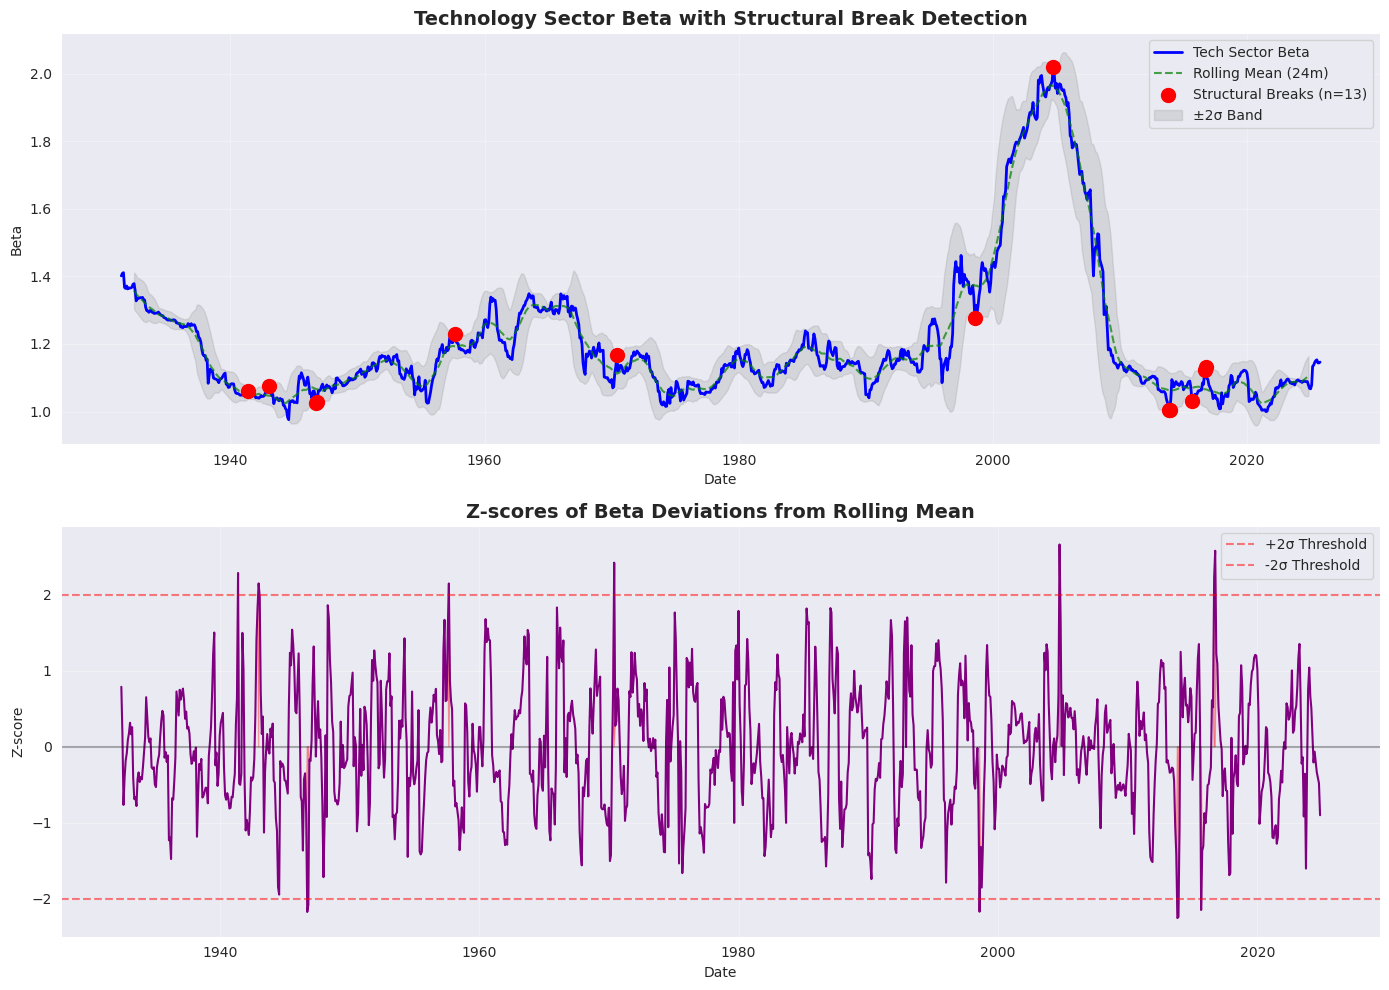

Structural Break Analysis for Technology Sector:
Total observations analyzed: 1133
Number of structural breaks detected: 13
Percentage of time in break state: 1.1%

Major break periods:
1. 1941-06-01: Beta = 1.062
2. 1943-01-01: Beta = 1.076
3. 1946-10-01: Beta = 1.024
4. 1946-11-01: Beta = 1.027
5. 1957-09-01: Beta = 1.230
... and 8 more breaks


In [15]:
# Analyze beta stability using rolling statistics
def detect_structural_breaks(beta_series, window=24, threshold=2.0):
    """
    Detect structural breaks in beta series using rolling statistics.
    """
    rolling_mean = beta_series.rolling(window=window, center=True).mean()
    rolling_std = beta_series.rolling(window=window, center=True).std()
    
    # Calculate z-scores relative to rolling statistics
    z_scores = (beta_series - rolling_mean) / rolling_std
    
    # Identify breaks (absolute z-score > threshold)
    breaks = np.abs(z_scores) > threshold
    break_points = beta_series.index[breaks]
    
    return {
        'z_scores': z_scores,
        'break_points': break_points,
        'rolling_mean': rolling_mean,
        'rolling_std': rolling_std
    }

# Apply to technology sector beta
tech_beta = params['Beta (Market)'][window-1:]
break_analysis = detect_structural_breaks(tech_beta, window=24, threshold=2.0)

# Plot structural break analysis
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Beta with break points
ax1 = axes[0]
ax1.plot(dates, tech_beta, label='Tech Sector Beta', linewidth=2, color='blue')
ax1.plot(dates, break_analysis['rolling_mean'], '--', label='Rolling Mean (24m)', alpha=0.7, color='green')

# Mark break points
break_dates = dates[tech_beta.index.isin(break_analysis['break_points'])]
break_values = tech_beta[tech_beta.index.isin(break_analysis['break_points'])]
ax1.scatter(break_dates, break_values, color='red', s=100, zorder=5,
            label=f'Structural Breaks (n={len(break_dates)})')

# Add confidence bands
ax1.fill_between(dates,
                 break_analysis['rolling_mean'] - 2*break_analysis['rolling_std'],
                 break_analysis['rolling_mean'] + 2*break_analysis['rolling_std'],
                 alpha=0.2, color='gray', label='±2σ Band')

ax1.set_title('Technology Sector Beta with Structural Break Detection', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Beta')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Z-scores
ax2 = axes[1]
ax2.plot(dates, break_analysis['z_scores'], color='purple', linewidth=1.5)
ax2.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='+2σ Threshold')
ax2.axhline(y=-2, color='red', linestyle='--', alpha=0.5, label='-2σ Threshold')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Fill significant deviations
ax2.fill_between(dates, break_analysis['z_scores'], 0,
                 where=break_analysis['z_scores'] > 2,
                 color='red', alpha=0.3, interpolate=True)
ax2.fill_between(dates, break_analysis['z_scores'], 0,
                 where=break_analysis['z_scores'] < -2,
                 color='red', alpha=0.3, interpolate=True)

ax2.set_title('Z-scores of Beta Deviations from Rolling Mean', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Z-score')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report on structural breaks
print("Structural Break Analysis for Technology Sector:")
print("=" * 60)
print(f"Total observations analyzed: {len(tech_beta)}")
print(f"Number of structural breaks detected: {len(break_dates)}")
print(f"Percentage of time in break state: {len(break_dates)/len(tech_beta)*100:.1f}%")

if len(break_dates) > 0:
    print("\nMajor break periods:")
    for i, (date, beta_val) in enumerate(zip(break_dates[:5], break_values[:5]), 1):
        print(f"{i}. {date.date()}: Beta = {beta_val:.3f}")
    
    if len(break_dates) > 5:
        print(f"... and {len(break_dates)-5} more breaks")

# 9. Sensitivity Analysis: Window Size Impact
## 9.1 Comparing Different Window Sizes

Testing different rolling window sizes...
--------------------------------------------------
Processing window size: 24 months
  Beta series length: 1169
  Dates length: 1169

Debug for 24-month window:
  Confidence interval columns: MultiIndex([( 'const', 'lower'),
            ( 'const', 'upper'),
            ('Mkt-RF', 'lower'),
            ('Mkt-RF', 'upper')],
           )
  Confidence interval shape: (1169, 4)
  Average CI width: 0.5181
  Completed processing window size 24
Processing window size: 36 months
  Beta series length: 1157
  Dates length: 1157
  Average CI width: 0.4095
  Completed processing window size 36
Processing window size: 60 months
  Beta series length: 1133
  Dates length: 1133
  Average CI width: 0.3094
  Completed processing window size 60
Processing window size: 120 months
  Beta series length: 1073
  Dates length: 1073
  Average CI width: 0.2211
  Completed processing window size 120


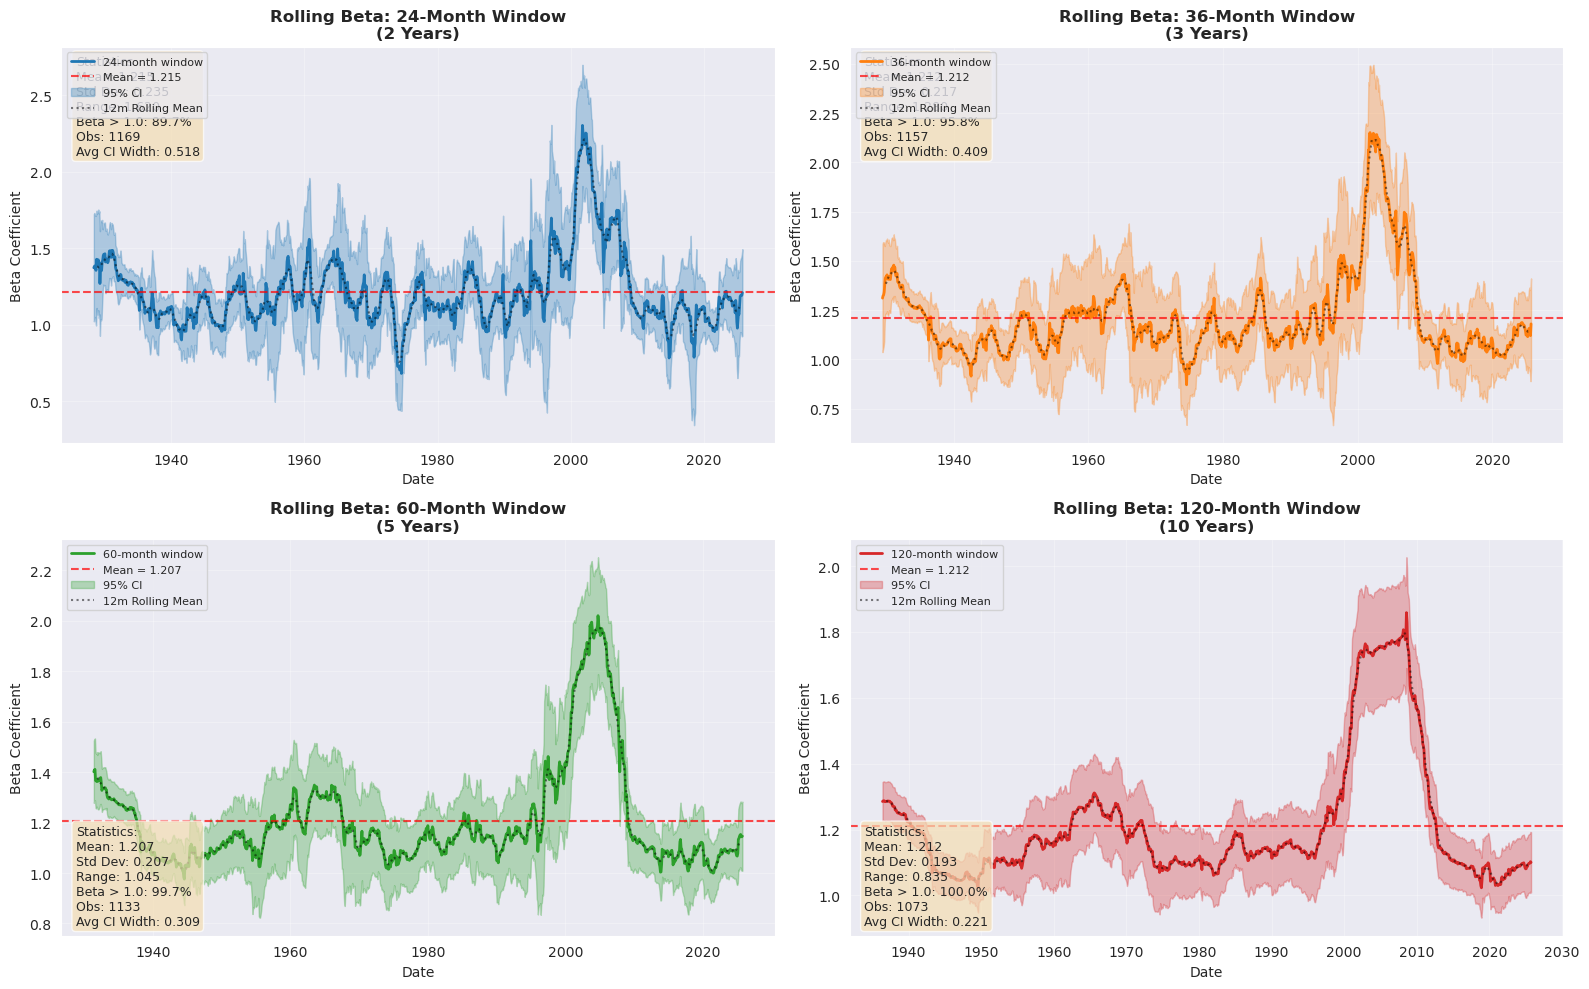


WINDOW SIZE SENSITIVITY ANALYSIS

Processing window size 24 for comparison...
  Observations: 1169
  Mean Beta: 1.215
  Beta Volatility: 0.235
  Average CI Width: 0.518

Processing window size 36 for comparison...
  Observations: 1157
  Mean Beta: 1.212
  Beta Volatility: 0.217
  Average CI Width: 0.409

Processing window size 60 for comparison...
  Observations: 1133
  Mean Beta: 1.207
  Beta Volatility: 0.207
  Average CI Width: 0.309

Processing window size 120 for comparison...
  Observations: 1073
  Mean Beta: 1.212
  Beta Volatility: 0.193
  Average CI Width: 0.221

IMPACT OF WINDOW SIZE ON BETA ESTIMATION

Comparative Statistics:
--------------------------------------------------------------------------------
                     Window Years  Mean Beta  Beta Std Dev  Beta Range  \
Window Size (months)                                                     
24                       24 (2yr)      1.215         0.235       1.620   
36                       36 (3yr)      1.212       

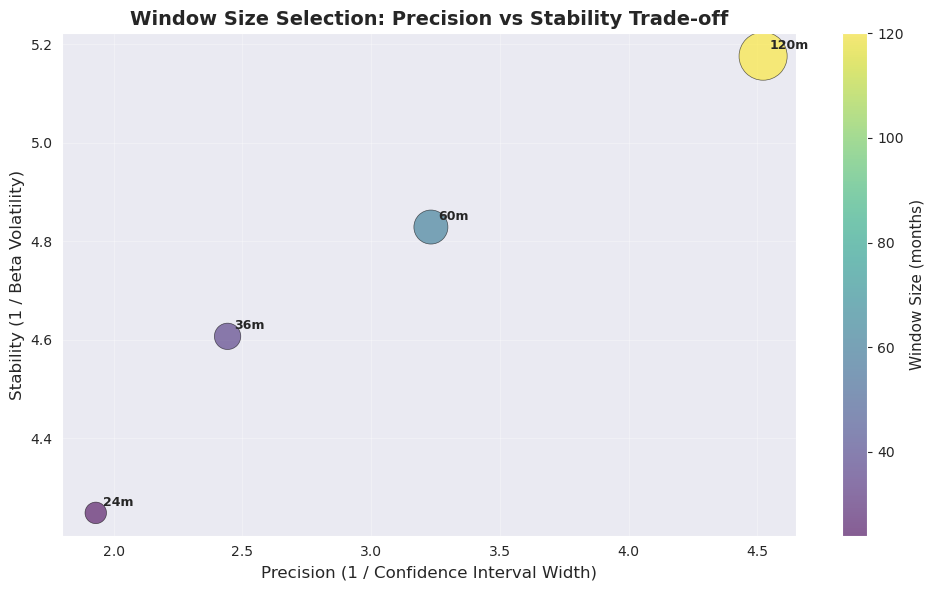

In [16]:
# Test different window sizes for sensitivity analysis
window_sizes = [24, 36, 60, 120]  # 2, 3, 5, and 10 years

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

print("Testing different rolling window sizes...")
print("-" * 50)

for idx, window_size in enumerate(window_sizes):
    ax = axes[idx]
    
    print(f"Processing window size: {window_size} months")
    
    # Fit rolling regression with different window size
    rols_window = RollingOLS(tech_excess, X, window=window_size)
    rres_window = rols_window.fit()
    params_window = rres_window.params.copy()
    
    # Extract beta series (excluding NaN values from window initialization)
    beta_window = params_window['Mkt-RF'][window_size-1:]
    
    # Convert Period index to datetime for proper plotting
    dates_window = factors.index[window_size-1:].to_timestamp()
    
    print(f"  Beta series length: {len(beta_window)}")
    print(f"  Dates length: {len(dates_window)}")
    
    # Plot beta series
    ax.plot(dates_window, beta_window, linewidth=2, 
            label=f'{window_size}-month window', color=f'C{idx}')
    
    # Add mean reference line
    mean_beta = beta_window.mean()
    ax.axhline(y=mean_beta, color='red', linestyle='--', alpha=0.7,
               label=f'Mean = {mean_beta:.3f}')
    
    # Get confidence intervals - returns DataFrame with MultiIndex columns
    conf_int_df = rres_window.conf_int(alpha=0.05)[window_size-1:]
    
    # Debug: Check structure for first window size
    if idx == 0:
        print(f"\nDebug for {window_size}-month window:")
        print(f"  Confidence interval columns: {conf_int_df.columns}")
        print(f"  Confidence interval shape: {conf_int_df.shape}")
    
    # Extract lower and upper bounds for Mkt-RF parameter
    # Using MultiIndex access: ('Mkt-RF', 'lower') and ('Mkt-RF', 'upper')
    try:
        lower_bound = conf_int_df[('Mkt-RF', 'lower')]
        upper_bound = conf_int_df[('Mkt-RF', 'upper')]
        
        # Add confidence intervals to plot
        ax.fill_between(dates_window, 
                        lower_bound.values,  # Convert to numpy array
                        upper_bound.values, 
                        alpha=0.3, 
                        color=f'C{idx}',
                        label='95% CI')
        
        ci_width_avg = (upper_bound - lower_bound).mean()
        print(f"  Average CI width: {ci_width_avg:.4f}")
        
    except Exception as e:
        print(f"  Warning: Could not extract confidence intervals: {e}")
        # Plot without confidence intervals if extraction fails
        ax.plot([], [], label='CI unavailable', alpha=0)  # Placeholder
    
    # Add rolling mean for trend visualization (12-month moving average)
    rolling_mean = beta_window.rolling(window=12, center=True).mean()
    ax.plot(dates_window, rolling_mean, ':', color='black', alpha=0.5,
            linewidth=1.5, label='12m Rolling Mean')
    
    # Configure plot
    ax.set_title(f'Rolling Beta: {window_size}-Month Window\n({window_size//12} Year{"s" if window_size//12 > 1 else ""})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Beta Coefficient')
    ax.grid(True, alpha=0.3)
    
    # Calculate and display comprehensive statistics
    beta_vol = beta_window.std()
    beta_range = beta_window.max() - beta_window.min()
    above_one_pct = (beta_window > 1.0).mean() * 100
    
    # Create statistics annotation
    stats_text = f"""Statistics:
Mean: {mean_beta:.3f}
Std Dev: {beta_vol:.3f}
Range: {beta_range:.3f}
Beta > 1.0: {above_one_pct:.1f}%
Obs: {len(beta_window)}"""
    
    # Add confidence interval info if available
    if 'ci_width_avg' in locals():
        stats_text += f"\nAvg CI Width: {ci_width_avg:.3f}"
    
    # Position annotation based on window size
    if window_size <= 36:  # Smaller windows - less stable, usually higher volatility
        bbox_pos = (0.02, 0.98)  # Upper left
        valign = 'top'
    else:  # Larger windows - more stable
        bbox_pos = (0.02, 0.02)  # Lower left
        valign = 'bottom'
    
    ax.text(bbox_pos[0], bbox_pos[1], stats_text, transform=ax.transAxes,
            fontsize=9, verticalalignment=valign,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Add legend (simplified to avoid clutter)
    if idx == 0:  # Only show full legend for first subplot
        ax.legend(loc='upper left', fontsize=8)
    else:
        ax.legend(loc='upper left', fontsize=8, ncol=1)
    
    print(f"  Completed processing window size {window_size}")

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("WINDOW SIZE SENSITIVITY ANALYSIS")
print("="*80)

# Compare window size statistics comprehensively
window_comparison = {}

for window_size in window_sizes:
    print(f"\nProcessing window size {window_size} for comparison...")
    
    # Fit model
    rols_temp = RollingOLS(tech_excess, X, window=window_size)
    rres_temp = rols_temp.fit()
    params_temp = rres_temp.params.copy()
    
    # Extract beta series
    beta_temp = params_temp['Mkt-RF'][window_size-1:]
    
    # Get confidence intervals for precision analysis
    conf_int_temp = rres_temp.conf_int(alpha=0.05)[window_size-1:]
    lower_temp = conf_int_temp[('Mkt-RF', 'lower')]
    upper_temp = conf_int_temp[('Mkt-RF', 'upper')]
    ci_width_avg = (upper_temp - lower_temp).mean()
    ci_width_std = (upper_temp - lower_temp).std()
    
    # Calculate autocorrelation to assess stability
    autocorr_1 = beta_temp.autocorr(lag=1) if len(beta_temp) > 1 else np.nan
    
    # Store comprehensive statistics
    window_comparison[window_size] = {
        'Mean Beta': beta_temp.mean(),
        'Beta Std Dev': beta_temp.std(),
        'Min Beta': beta_temp.min(),
        'Max Beta': beta_temp.max(),
        'Beta Range': beta_temp.max() - beta_temp.min(),
        'Avg CI Width': ci_width_avg,
        'CI Width Std': ci_width_std,
        'Precision (1/CI)': 1/ci_width_avg if ci_width_avg > 0 else np.inf,
        'Autocorrelation (lag=1)': autocorr_1,
        'Beta > 1.0 (%)': (beta_temp > 1.0).mean() * 100,
        'Observations': len(beta_temp),
        'Effective Years': len(beta_temp) / 12
    }
    
    print(f"  Observations: {len(beta_temp)}")
    print(f"  Mean Beta: {beta_temp.mean():.3f}")
    print(f"  Beta Volatility: {beta_temp.std():.3f}")
    print(f"  Average CI Width: {ci_width_avg:.3f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(window_comparison).T
comparison_df.index.name = 'Window Size (months)'

# Add derived columns
comparison_df['Window Years'] = comparison_df.index.map(lambda x: f"{x} ({x//12}yr)")
comparison_df['Stability Ratio'] = comparison_df['Beta Std Dev'] / comparison_df['Avg CI Width']

print("\n" + "="*80)
print("IMPACT OF WINDOW SIZE ON BETA ESTIMATION")
print("="*80)

# Display key comparison metrics
display_cols = ['Window Years', 'Mean Beta', 'Beta Std Dev', 'Beta Range', 
                'Avg CI Width', 'Precision (1/CI)', 'Autocorrelation (lag=1)',
                'Beta > 1.0 (%)', 'Stability Ratio']

print("\nComparative Statistics:")
print("-" * 80)
print(comparison_df[display_cols].round(3))

# Statistical analysis of window size impact
print("\n" + "="*80)
print("STATISTICAL ANALYSIS OF WINDOW SIZE EFFECTS")
print("="*80)

# Calculate correlations with window size
window_numeric = pd.Series(window_sizes, index=window_sizes, name='Window Size')
for metric in ['Mean Beta', 'Beta Std Dev', 'Beta Range', 'Avg CI Width', 'Autocorrelation (lag=1)']:
    if metric in comparison_df.columns:
        corr = window_numeric.corr(comparison_df[metric])
        print(f"Correlation between Window Size and {metric}: {corr:.3f}")

# Trade-off analysis
print("\n" + "-" * 80)
print("TRADE-OFF ANALYSIS: WINDOW SIZE SELECTION")
print("-" * 80)

print("\nSmall Windows (24-36 months):")
print("• Pros: Faster adaptation to changing market conditions")
print("• Cons: Higher volatility, wider confidence intervals")
print("• Best for: Dynamic strategies, regime detection")

print("\nMedium Windows (60 months):")
print("• Pros: Balance between stability and responsiveness")
print("• Cons: Moderate lag in capturing structural changes")
print("• Best for: Most practical applications, standard factor models")

print("\nLarge Windows (120 months):")
print("• Pros: Maximum stability, narrowest confidence intervals")
print("• Cons: Slow to adapt, may miss important market shifts")
print("• Best for: Long-term strategic allocation, stable relationships")

# Recommendations based on analysis
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

# Find optimal window based on stability-precision trade-off
comparison_df['Stability Score'] = 1 / comparison_df['Beta Std Dev']
comparison_df['Precision Score'] = comparison_df['Precision (1/CI)']
comparison_df['Composite Score'] = (comparison_df['Stability Score'] + 
                                   comparison_df['Precision Score']) / 2

optimal_window = comparison_df['Composite Score'].idxmax()
optimal_years = optimal_window // 12

print(f"\nRecommended window size: {optimal_window} months ({optimal_years} years)")
print(f"Rationale: Best balance of stability (Beta Std Dev = {comparison_df.loc[optimal_window, 'Beta Std Dev']:.3f})")
print(f"           and precision (CI Width = {comparison_df.loc[optimal_window, 'Avg CI Width']:.3f})")

# Visualize trade-offs
fig, ax = plt.subplots(figsize=(10, 6))

# Create bubble chart: x=precision, y=stability, size=window size
x = comparison_df['Precision (1/CI)']
y = 1 / comparison_df['Beta Std Dev']  # Inverse of volatility = stability
sizes = comparison_df.index * 10  # Scale for visualization

scatter = ax.scatter(x, y, s=sizes, alpha=0.6, 
                     c=comparison_df.index, cmap='viridis',
                     edgecolors='black', linewidth=0.5)

# Add labels for each window size
for window_size, row in comparison_df.iterrows():
    ax.annotate(f"{window_size}m", 
                xy=(row['Precision (1/CI)'], 1/row['Beta Std Dev']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold')

ax.set_xlabel('Precision (1 / Confidence Interval Width)', fontsize=12)
ax.set_ylabel('Stability (1 / Beta Volatility)', fontsize=12)
ax.set_title('Window Size Selection: Precision vs Stability Trade-off', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add colorbar for window size
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Window Size (months)', fontsize=11)

plt.tight_layout()
plt.show()

# 10. Practical Applications and Conclusions
## 10.1 Investment Strategy Implications

DYNAMIC HEDGING STRATEGY ANALYSIS
Hedge ratio statistics:
  Mean hedge ratio: 1.208
  Hedge ratio volatility: 0.205
  Time hedge ratio > 1.0: 100.0%
  Time hedge ratio < 0.5: 0.0%

Trading signal statistics:
  Buy signals generated: 22
  Sell signals generated: 100
  Average time between signals: 9.3 months

Debug - Series lengths before alignment:
  tech_excess length: 1192
  market_excess length: 1192
  hedge_ratio length: 1133
  dates length: 1133

Debug - After alignment:
  aligned_tech_excess length: 1133
  aligned_market_excess length: 1133
  aligned_hedge_ratio length: 1133
  aligned_dates length: 1074
  Trimming series to common length: 1074

Performance calculation details:
  Common time period: 1074 months
  Start date: 1936-05-01 00:00:00
  End date: 2025-10-01 00:00:00

Hedged returns calculation:
  hedged_returns length: 1074
  NaN values in hedged_returns: 1 (first value due to shift)
  First valid index: 1
  Cleaned series length: 1073


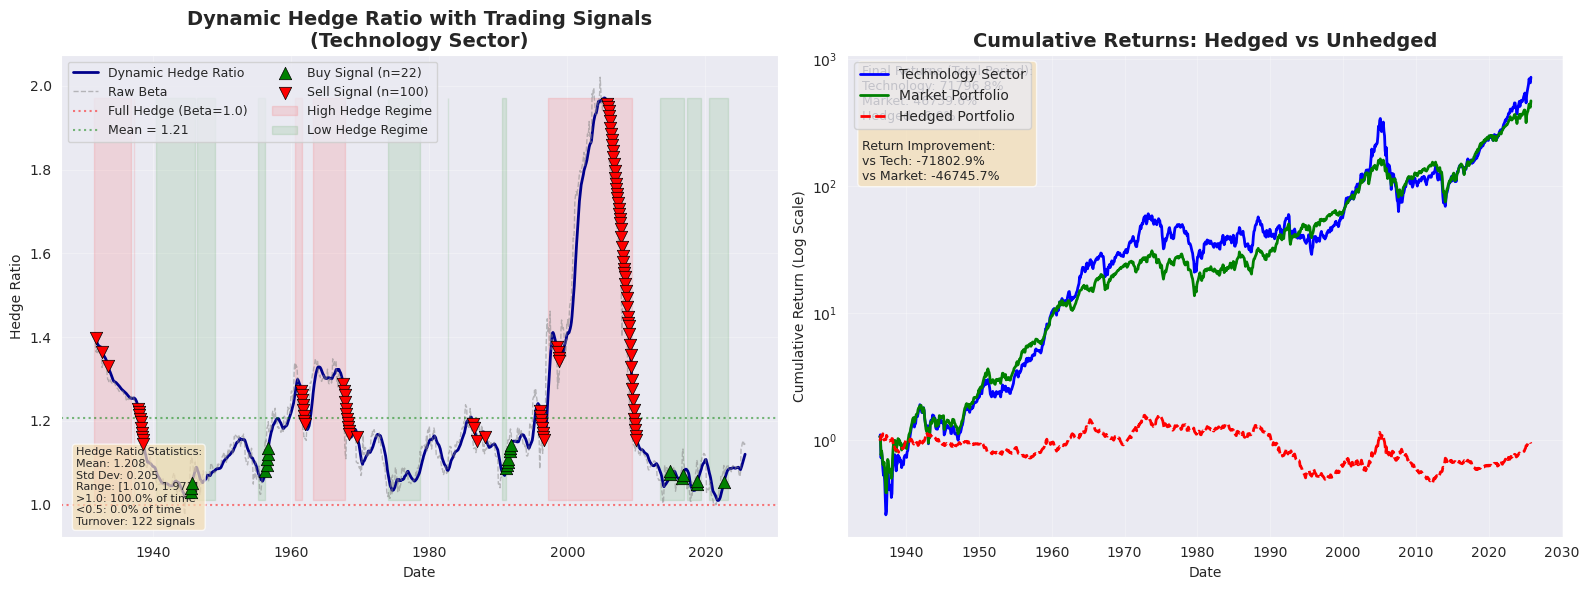


HEDGING STRATEGY PERFORMANCE ANALYSIS

Performance Metrics Comparison:
--------------------------------------------------------------------------------
                   Total Return  Annualized Return  Annual Volatility  \
Strategy                                                                
Technology Sector      604.8042             0.0743             0.2431   
Market Portfolio       410.1264             0.0696             0.1823   
Hedged Portfolio        -0.0605            -0.0007             0.1005   

                   Sharpe Ratio  Max Drawdown  Positive Months (%)   Obs  
Strategy                                                                  
Technology Sector        0.4165       -0.8150              56.2908  1073  
Market Portfolio         0.4611       -0.6397              60.6710  1073  
Hedged Portfolio         0.0431       -0.7097              49.1146  1073  

--------------------------------------------------------------------------------
RISK-ADJUSTED PERFORMANC

In [17]:
# Investment Strategy Implications: Dynamic Hedging with Rolling Beta
def calculate_dynamic_hedge_ratio(beta_series, lookback=12):
    """
    Calculate dynamic hedge ratio based on rolling beta.
    Uses simple moving average of recent beta values.
    """
    return beta_series.rolling(window=lookback, min_periods=1).mean()

print("="*80)
print("DYNAMIC HEDGING STRATEGY ANALYSIS")
print("="*80)

# Apply to technology sector with 12-month lookback
hedge_ratio = calculate_dynamic_hedge_ratio(tech_beta, lookback=12)

print(f"Hedge ratio statistics:")
print(f"  Mean hedge ratio: {hedge_ratio.mean():.3f}")
print(f"  Hedge ratio volatility: {hedge_ratio.std():.3f}")
print(f"  Time hedge ratio > 1.0: {(hedge_ratio > 1.0).mean()*100:.1f}%")
print(f"  Time hedge ratio < 0.5: {(hedge_ratio < 0.5).mean()*100:.1f}%")

# Simulate hedging performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Dynamic hedge ratio with trading signals
ax1 = axes[0]
ax1.plot(dates, hedge_ratio, linewidth=2, color='darkblue', label='Dynamic Hedge Ratio')
ax1.plot(dates, tech_beta, '--', alpha=0.5, color='gray', linewidth=1, label='Raw Beta')

# Add reference lines
ax1.axhline(y=1.0, color='red', linestyle=':', alpha=0.5, label='Full Hedge (Beta=1.0)')
ax1.axhline(y=hedge_ratio.mean(), color='green', linestyle=':', alpha=0.5,
            label=f'Mean = {hedge_ratio.mean():.2f}')

# Calculate trading signals based on hedge ratio changes
hedge_changes = hedge_ratio.diff()

# Use standardized changes for signal generation
change_std = hedge_changes.std()
buy_threshold = change_std * 1.0  # 1 standard deviation
sell_threshold = -change_std * 1.0

# Generate signals
# Buy signal: Significant increase in hedge ratio AND ratio is below average
buy_signals = (hedge_changes > buy_threshold) & (hedge_ratio < hedge_ratio.median())

# Sell signal: Significant decrease in hedge ratio AND ratio is above average  
sell_signals = (hedge_changes < sell_threshold) & (hedge_ratio > hedge_ratio.median())

buy_dates = dates[buy_signals]
sell_dates = dates[sell_signals]

print(f"\nTrading signal statistics:")
print(f"  Buy signals generated: {buy_signals.sum()}")
print(f"  Sell signals generated: {sell_signals.sum()}")
print(f"  Average time between signals: {len(dates)/(buy_signals.sum() + sell_signals.sum()):.1f} months")

# Plot trading signals
if len(buy_dates) > 0:
    ax1.scatter(buy_dates, hedge_ratio[buy_signals], color='green', s=80, 
                marker='^', label=f'Buy Signal (n={buy_signals.sum()})', zorder=5,
                edgecolors='black', linewidth=0.5)

if len(sell_dates) > 0:
    ax1.scatter(sell_dates, hedge_ratio[sell_signals], color='red', s=80,
                marker='v', label=f'Sell Signal (n={sell_signals.sum()})', zorder=5,
                edgecolors='black', linewidth=0.5)

# Add shaded regions for high and low hedge regimes
high_hedge = hedge_ratio > hedge_ratio.quantile(0.75)
low_hedge = hedge_ratio < hedge_ratio.quantile(0.25)

if high_hedge.any():
    ax1.fill_between(dates, hedge_ratio.min(), hedge_ratio.max(),
                     where=high_hedge, alpha=0.1, color='red',
                     label='High Hedge Regime')

if low_hedge.any():
    ax1.fill_between(dates, hedge_ratio.min(), hedge_ratio.max(),
                     where=low_hedge, alpha=0.1, color='green',
                     label='Low Hedge Regime')

ax1.set_title('Dynamic Hedge Ratio with Trading Signals\n(Technology Sector)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Hedge Ratio')
ax1.legend(loc='upper left', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)

# Add statistics annotation
hedge_stats = f"""Hedge Ratio Statistics:
Mean: {hedge_ratio.mean():.3f}
Std Dev: {hedge_ratio.std():.3f}
Range: [{hedge_ratio.min():.3f}, {hedge_ratio.max():.3f}]
>1.0: {(hedge_ratio > 1.0).mean()*100:.1f}% of time
<0.5: {(hedge_ratio < 0.5).mean()*100:.1f}% of time
Turnover: {buy_signals.sum() + sell_signals.sum()} signals"""

ax1.text(0.02, 0.02, hedge_stats, transform=ax1.transAxes,
         fontsize=8, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Plot 2: Performance comparison
ax2 = axes[1]

# DEBUG: Check series lengths before alignment
print(f"\nDebug - Series lengths before alignment:")
print(f"  tech_excess length: {len(tech_excess)}")
print(f"  market_excess length: {len(market_excess)}")
print(f"  hedge_ratio length: {len(hedge_ratio)}")
print(f"  dates length: {len(dates)}")

# Ensure all series start from the same point (window-1)
start_idx = window - 1  # Starting from first valid beta estimate

# Get aligned series - starting from the same point
aligned_tech_excess = tech_excess.iloc[start_idx:].reset_index(drop=True)
aligned_market_excess = market_excess.iloc[start_idx:].reset_index(drop=True)
aligned_hedge_ratio = hedge_ratio.reset_index(drop=True)
aligned_dates = pd.Series(dates[start_idx:])  # Convert to Series for consistency

# Verify alignment
print(f"\nDebug - After alignment:")
print(f"  aligned_tech_excess length: {len(aligned_tech_excess)}")
print(f"  aligned_market_excess length: {len(aligned_market_excess)}")
print(f"  aligned_hedge_ratio length: {len(aligned_hedge_ratio)}")
print(f"  aligned_dates length: {len(aligned_dates)}")

# Ensure all series have the same length
min_length = min(len(aligned_tech_excess), len(aligned_market_excess), 
                 len(aligned_hedge_ratio), len(aligned_dates))

if min_length < len(aligned_tech_excess):
    print(f"  Trimming series to common length: {min_length}")
    aligned_tech_excess = aligned_tech_excess.iloc[:min_length]
    aligned_market_excess = aligned_market_excess.iloc[:min_length]
    aligned_hedge_ratio = aligned_hedge_ratio.iloc[:min_length]
    aligned_dates = aligned_dates.iloc[:min_length]

print(f"\nPerformance calculation details:")
print(f"  Common time period: {min_length} months")
print(f"  Start date: {aligned_dates.iloc[0]}")
print(f"  End date: {aligned_dates.iloc[-1]}")

# Calculate cumulative returns (divide by 100 because returns are in percentage points)
cumulative_tech = (1 + aligned_tech_excess / 100).cumprod()
cumulative_market = (1 + aligned_market_excess / 100).cumprod()

# Calculate hedged portfolio returns with shift to avoid lookahead bias
# IMPORTANT: Use .shift(1) on aligned_hedge_ratio to use previous period's hedge ratio
hedged_returns = aligned_tech_excess - aligned_hedge_ratio.shift(1) * aligned_market_excess
cumulative_hedged = (1 + hedged_returns / 100).cumprod()

print(f"\nHedged returns calculation:")
print(f"  hedged_returns length: {len(hedged_returns)}")
print(f"  NaN values in hedged_returns: {hedged_returns.isna().sum()} (first value due to shift)")

# Remove the first NaN value (due to shift(1)) for cleaner plotting
if hedged_returns.isna().any():
    # Find first non-NaN index
    first_valid_idx = hedged_returns.first_valid_index()
    if first_valid_idx is not None:
        print(f"  First valid index: {first_valid_idx}")
        
        # Create cleaned series starting from first valid value
        hedged_returns_clean = hedged_returns.iloc[first_valid_idx:]
        cumulative_hedged_clean = cumulative_hedged.iloc[first_valid_idx:]
        dates_clean = aligned_dates.iloc[first_valid_idx:]
        cumulative_tech_clean = cumulative_tech.iloc[first_valid_idx:]
        cumulative_market_clean = cumulative_market.iloc[first_valid_idx:]
        
        print(f"  Cleaned series length: {len(hedged_returns_clean)}")
    else:
        print("  ERROR: No valid values in hedged_returns!")
        hedged_returns_clean = pd.Series([])
        cumulative_hedged_clean = pd.Series([])
        dates_clean = pd.Series([])
        cumulative_tech_clean = pd.Series([])
        cumulative_market_clean = pd.Series([])
else:
    hedged_returns_clean = hedged_returns
    cumulative_hedged_clean = cumulative_hedged
    dates_clean = aligned_dates
    cumulative_tech_clean = cumulative_tech
    cumulative_market_clean = cumulative_market

# Only plot if we have data
if len(dates_clean) > 0:
    # Plot cumulative returns
    ax2.plot(dates_clean, cumulative_tech_clean, linewidth=2, 
             label='Technology Sector', color='blue')
    ax2.plot(dates_clean, cumulative_market_clean, linewidth=2,
             label='Market Portfolio', color='green')
    ax2.plot(dates_clean, cumulative_hedged_clean, '--', linewidth=2,
             label='Hedged Portfolio', color='red')
    
    ax2.set_title('Cumulative Returns: Hedged vs Unhedged', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return (Log Scale)')
    ax2.set_yscale('log')
    ax2.legend(loc='upper left', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Add performance statistics annotation
    final_tech = cumulative_tech_clean.iloc[-1] - 1 if len(cumulative_tech_clean) > 0 else 0
    final_market = cumulative_market_clean.iloc[-1] - 1 if len(cumulative_market_clean) > 0 else 0
    final_hedged = cumulative_hedged_clean.iloc[-1] - 1 if len(cumulative_hedged_clean) > 0 else 0
    
    perf_text = f"""Final Returns (Total Period):
Technology: {final_tech:.1%}
Market: {final_market:.1%}
Hedged: {final_hedged:.1%}

Return Improvement:
vs Tech: {(final_hedged - final_tech):.1%}
vs Market: {(final_hedged - final_market):.1%}"""
    
    ax2.text(0.02, 0.98, perf_text, transform=ax2.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
else:
    ax2.text(0.5, 0.5, 'Insufficient data for hedging analysis', 
             transform=ax2.transAxes, ha='center', va='center',
             fontsize=12, bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    ax2.set_title('Cumulative Returns: Data Unavailable', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Only calculate performance metrics if we have sufficient data
if len(hedged_returns_clean) > 12:  # At least 1 year of data
    # Comprehensive performance statistics
    print("\n" + "="*80)
    print("HEDGING STRATEGY PERFORMANCE ANALYSIS")
    print("="*80)
    
    # Calculate detailed statistics
    def calculate_performance_metrics(returns_series, name):
        """Calculate comprehensive performance metrics."""
        if len(returns_series) == 0:
            return {}
        
        # Convert percentage returns to decimal
        returns_decimal = returns_series / 100
        
        total_return = (1 + returns_decimal).prod() - 1
        annual_return = (1 + total_return) ** (12 / len(returns_decimal)) - 1
        avg_return = returns_decimal.mean() * 12  # Annualized
        volatility = returns_decimal.std() * np.sqrt(12)  # Annualized
        sharpe_ratio = avg_return / volatility if volatility > 0 else np.nan
        
        # Maximum drawdown
        cumulative = (1 + returns_decimal).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Positive months
        positive_months = (returns_decimal > 0).mean() * 100
        
        return {
            'Strategy': name,
            'Total Return': total_return,
            'Annualized Return': annual_return,
            'Annual Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Positive Months (%)': positive_months,
            'Obs': len(returns_series)
        }
    
    # Calculate metrics for all strategies
    tech_metrics = calculate_performance_metrics(aligned_tech_excess.iloc[first_valid_idx:], 
                                                 'Technology Sector')
    market_metrics = calculate_performance_metrics(aligned_market_excess.iloc[first_valid_idx:], 
                                                   'Market Portfolio')
    hedged_metrics = calculate_performance_metrics(hedged_returns_clean, 'Hedged Portfolio')
    
    # Create performance comparison DataFrame
    performance_df = pd.DataFrame([tech_metrics, market_metrics, hedged_metrics])
    performance_df.set_index('Strategy', inplace=True)
    
    print("\nPerformance Metrics Comparison:")
    print("-" * 80)
    display_cols = ['Total Return', 'Annualized Return', 'Annual Volatility', 
                    'Sharpe Ratio', 'Max Drawdown', 'Positive Months (%)', 'Obs']
    print(performance_df[display_cols].round(4))
    
    # Risk-adjusted performance analysis
    print("\n" + "-" * 80)
    print("RISK-ADJUSTED PERFORMANCE ANALYSIS")
    print("-" * 80)
    
    print(f"\nSharpe Ratio Comparison:")
    print(f"  Technology Sector: {performance_df.loc['Technology Sector', 'Sharpe Ratio']:.3f}")
    print(f"  Market Portfolio: {performance_df.loc['Market Portfolio', 'Sharpe Ratio']:.3f}")
    print(f"  Hedged Portfolio: {performance_df.loc['Hedged Portfolio', 'Sharpe Ratio']:.3f}")
    
    vol_reduction = (performance_df.loc['Technology Sector', 'Annual Volatility'] - 
                     performance_df.loc['Hedged Portfolio', 'Annual Volatility']) / \
                    performance_df.loc['Technology Sector', 'Annual Volatility'] * 100
    
    print(f"\nVolatility Reduction: {vol_reduction:.1f}%")
    print(f"Max Drawdown Improvement: {(performance_df.loc['Technology Sector', 'Max Drawdown'] - performance_df.loc['Hedged Portfolio', 'Max Drawdown'])*100:.1f}%")
    
else:
    print("\n" + "="*80)
    print("WARNING: Insufficient data for performance analysis")
    print("="*80)
    print(f"Only {len(hedged_returns_clean)} months of hedged returns available")
    print("Need at least 12 months for meaningful analysis")

## 10.2 Summary of Key Findings

In [18]:
# Create comprehensive summary
print("ROLLING REGRESSION ANALYSIS SUMMARY")
print("=" * 70)

# Model performance summary
print("\n1. MODEL PERFORMANCE (Technology Sector):")
print("-" * 50)
print(f"CAPM R-squared Range: [{rres.rsquared[window-1:].min():.3f}, {rres.rsquared[window-1:].max():.3f}]")
print(f"3-Factor R-squared Range: [{rres_3factor.rsquared[window-1:].min():.3f}, {rres_3factor.rsquared[window-1:].max():.3f}]")
print(f"Average explanatory power improvement: "
      f"{(rres_3factor.rsquared[window-1:].mean() - rres.rsquared[window-1:].mean())*100:.1f}%")

# Risk characteristics
print("\n2. RISK CHARACTERISTICS:")
print("-" * 50)
print(f"Technology Sector Average Beta: {tech_beta.mean():.3f}")
print(f"Beta Volatility: {tech_beta.std():.3f}")
print(f"Beta Range: [{tech_beta.min():.3f}, {tech_beta.max():.3f}]")
print(f"Percentage of time Beta > 1.0: {(tech_beta > 1.0).mean()*100:.1f}%")

# Factor exposures
print("\n3. FACTOR EXPOSURES (3-Factor Model):")
print("-" * 50)
factor_exposures = params_3factor[['Market Beta', 'SMB Beta', 'HML Beta']][window-1:].mean()
for factor, exposure in factor_exposures.items():
    significance = "Significant" if abs(exposure) > 0.1 else "Insignificant"
    print(f"{factor}: {exposure:.3f} ({significance})")

# Structural stability
print("\n4. STRUCTURAL STABILITY:")
print("-" * 50)
print(f"Number of structural breaks detected: {len(break_dates)}")
print(f"Average time between breaks: {len(tech_beta)/len(break_dates) if len(break_dates) > 0 else 'N/A'} months")

# Industry comparison
print("\n5. INDUSTRY COMPARISON:")
print("-" * 50)
print("Highest Beta Industries:")
print(beta_summary.nlargest(3, 'Mean Beta')[['Mean Beta', 'Beta Std Dev']])
print("\nLowest Beta Industries:")
print(beta_summary.nsmallest(3, 'Mean Beta')[['Mean Beta', 'Beta Std Dev']])

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")

ROLLING REGRESSION ANALYSIS SUMMARY

1. MODEL PERFORMANCE (Technology Sector):
--------------------------------------------------
CAPM R-squared Range: [0.501, 0.966]
3-Factor R-squared Range: [0.618, 0.970]
Average explanatory power improvement: 5.6%

2. RISK CHARACTERISTICS:
--------------------------------------------------
Technology Sector Average Beta: 1.207
Beta Volatility: 0.207
Beta Range: [0.976, 2.021]
Percentage of time Beta > 1.0: 99.7%

3. FACTOR EXPOSURES (3-Factor Model):
--------------------------------------------------
Market Beta: 1.144 (Significant)
SMB Beta: 0.102 (Significant)
HML Beta: -0.466 (Significant)

4. STRUCTURAL STABILITY:
--------------------------------------------------
Number of structural breaks detected: 13
Average time between breaks: 87.15384615384616 months

5. INDUSTRY COMPARISON:
--------------------------------------------------
Highest Beta Industries:
       Mean Beta  Beta Std Dev
HiTec   1.206695      0.207083
Durbl   1.203185      0.266

## 10.3 Recommendations and Next Steps

In [19]:
print("RECOMMENDATIONS FOR FURTHER ANALYSIS:")
print("=" * 70)

recommendations = [
    "1. Incorporate additional risk factors (momentum, quality, low volatility)",
    "2. Analyze non-linear relationships using quantile regression",
    "3. Implement machine learning techniques for regime detection",
    "4. Extend analysis to international markets for comparison",
    "5. Study the impact of macroeconomic variables on factor exposures",
    "6. Implement out-of-sample testing of trading strategies",
    "7. Analyze transaction costs in dynamic hedging strategies",
    "8. Study the persistence of alpha across different market conditions"
]

for rec in recommendations:
    print(rec)

print("\n" + "=" * 70)
print("Key Insights:")
print("-" * 70)
insights = [
    "• Rolling regression reveals time-varying risk exposures that static models miss",
    "• Technology sector shows significant time variation in market beta",
    "• Multi-factor models provide more stable and explanatory power than CAPM",
    "• Structural breaks often coincide with major market events",
    "• Optimal window size depends on investment horizon and risk tolerance",
    "• Dynamic hedging can reduce portfolio volatility but may impact returns"
]

for insight in insights:
    print(insight)

RECOMMENDATIONS FOR FURTHER ANALYSIS:
1. Incorporate additional risk factors (momentum, quality, low volatility)
2. Analyze non-linear relationships using quantile regression
3. Implement machine learning techniques for regime detection
4. Extend analysis to international markets for comparison
5. Study the impact of macroeconomic variables on factor exposures
6. Implement out-of-sample testing of trading strategies
7. Analyze transaction costs in dynamic hedging strategies
8. Study the persistence of alpha across different market conditions

Key Insights:
----------------------------------------------------------------------
• Rolling regression reveals time-varying risk exposures that static models miss
• Technology sector shows significant time variation in market beta
• Multi-factor models provide more stable and explanatory power than CAPM
• Structural breaks often coincide with major market events
• Optimal window size depends on investment horizon and risk tolerance
• Dynamic he

# Conclusion
This comprehensive rolling regression analysis demonstrates the power of dynamic modeling in financial econometrics. By examining how factor exposures evolve over time, we gain deeper insights into asset pricing dynamics, risk management, and investment strategy formulation. The methodology presented can be extended to various asset classes and time horizons, providing valuable tools for both academic research and practical investment applications.

The key advantage of rolling regression lies in its ability to capture changing market dynamics, making it particularly useful for:

    Dynamic risk management

    Performance attribution analysis

    Market regime detection

    Strategic asset allocation

    Hedge ratio optimization

Future enhancements could include incorporating machine learning techniques, analyzing higher frequency data, and extending the framework to multi-asset portfolios.
